In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import copy
import glob
import time
from scipy.optimize import minimize



In [2]:
#Load the dataset from file 
path = "C:/Users/Krasn/Documents/Jupyter/Test Trading Bot/history_data/spot ETHUSDT-5m/" # use your path
all_files = glob.glob(path + "*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=None)
    li.append(df)
   
frame = pd.concat(li, axis=0, ignore_index=True)
frame.drop([6,7,8,9,10,11], axis=1, inplace=True)
frame.rename(columns={ 0:'timestamp',
                     1:'open',
                     2:'high',
                     3:'low',
                     4:'close',
                     5:'volume'}, inplace=True)
frame['timestamp'] = pd.to_datetime(frame['timestamp']//1000,unit='s')
print(len(frame))
df_train = copy.copy(frame[0:1000])
df_test1 = copy.copy(frame[1000:1500].reset_index())
df_test2 = copy.copy(frame[1500:len(frame)].reset_index())
df_train

2016


,timestamp,open,high,low,close,volume
0,2022-06-01 00:00:00,1941.90,1946.99,1941.31,1945.29,3674.8988
1,2022-06-01 00:05:00,1945.30,1949.30,1944.81,1944.82,1621.1472
2,2022-06-01 00:10:00,1944.82,1945.20,1932.56,1937.09,4869.7026
3,2022-06-01 00:15:00,1937.10,1947.39,1936.98,1945.01,4108.2555
4,2022-06-01 00:20:00,1945.00,1945.01,1930.02,1934.47,3477.5123
...,...,...,...,...,...,...
995,2022-06-04 10:55:00,1773.28,1773.68,1772.84,1773.67,407.8080
996,2022-06-04 11:00:00,1773.67,1774.80,1773.67,1774.15,304.1485
997,2022-06-04 11:05:00,1774.15,1774.55,1773.08,1773.56,480.3090
998,2022-06-04 11:10:00,1773.56,1773.75,1772.09,1773.18,413.2440


In [3]:
# To find a slope of price line
# series - dataframe 'close' indSlope(df['close'],5)
# n - num of kandels, 5 by default

def indSlope(series,n):   
    array_sl = [j*0 for j in range(n-1)]
    for j in range(n,len(series)+1):
        y = series[j-n:j]
        x = np.array(range(n))
        x_sc = (x - x.min())/(x.max() - x.min())
        y_sc = (y - y.min())/(y.max() - y.min())
        x_sc = sm.add_constant(x_sc)
        model = sm.OLS(y_sc,x_sc)
        results = model.fit()
        array_sl.append(results.params[-1])
    slope_angle = (np.rad2deg(np.arctan(np.array(array_sl))))
    return np.array(slope_angle)

In [4]:
# True Range and Average True Range indicator
# source_DF
#n - num of kandels, 14 by default

def indATR(source_DF,n=14):
    df = source_DF.copy()
    df['H-L']=abs(df['high']-df['low'])
    df['H-PC']=abs(df['high']-df['close'].shift(1))
    df['L-PC']=abs(df['low']-df['close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    df_temp = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df_temp


# find local mimimum / local maximum
# DF - dataframe
# i  - row in dataframe
def isLCC(DF,i):
    df=DF.copy()
    LCC=0
    if df['close'][i]<=df['close'][i+1] and df['close'][i]<=df['close'][i-1] and df['close'][i+1]>df['close'][i-1]:
        #found the local low
        LCC = i-1;
    return LCC

def isHCC(DF,i):
    df=DF.copy()
    HCC=0
    if df['close'][i]>=df['close'][i+1] and df['close'][i]>=df['close'][i-1] and df['close'][i+1]<df['close'][i-1]:
        #found the local high
        HCC = i;
    return HCC

def getMaxMinChannel(DF, n):
    maxx=0
    minn=DF['low'].max()
    for i in range (1,n):
        if maxx<DF['high'][len(DF)-i]:
            maxx=DF['high'][len(DF)-i]
        if minn>DF['low'][len(DF)-i]:
            minn=DF['low'][len(DF)-i]
    return(maxx,minn)

def check_if_signal(prepared_df):
    '''
    ohlc = get_futures_klines(symbol,100)
    prepared_df = PrepareDF(ohlc)
    '''
    
    signal=None # return value
    
    i=len(prepared_df)-1 # 99 is current kandel which is not closed, 98 is last closed candel, we need 97 to check if it is bottom or top
    
    if isLCC(prepared_df,i-1)>0:
       # found bottom - OPEN LONG
        if prepared_df['position_in_channel'][i-1]<0.5:
            # close to top of channel
            if prepared_df['slope'][i-1]<-20:
                # found a good enter point for LONG
                signal='long'

    if isHCC(prepared_df,i-1)>0:
       # found top - OPEN SHORT
        if prepared_df['position_in_channel'][i-1]>0.5:
            # close to top of channel
            if prepared_df['slope'][i-1]>20:
                # found a good enter point for SHORT
                signal='short'

    return signal, prepared_df.at[i,'close']

In [5]:
# generate data frame with all needed data:
# slope
# channel_max
# channel_min
# position_in_channel
# DF - dataframe
def PrepareDF(DF):
    ohlc = DF.iloc[:,[0,1,2,3,4,5]]
    ohlc.columns = ["timestamp","open","high","low","close","volume"]
    ohlc=ohlc.set_index('timestamp')
    df = indATR(ohlc,14).reset_index() #  <====try to optimize
    df['slope'] = indSlope(df['close'],5) #  <====try to optimize
    df['channel_max'] = df['high'].rolling(10).max() #  <====try to optimize
    df['channel_min'] = df['low'].rolling(10).min() #  <====try to optimize
    df['position_in_channel'] = (df['close']-df['channel_min']) / (df['channel_max']-df['channel_min'])
    df = df.set_index('timestamp')
    df = df.reset_index()
    return(df)

In [42]:
d_frame = df_train
#one close at time
work_df =[]
work_df = pd.DataFrame(columns=["timestamp","open","high","low","close","volume"])

t = time.perf_counter()

for i in range(len(d_frame)):
    if len(work_df) <= 30:
        work_df.loc[frame.index[i]] = frame.iloc[i]
        work_df.reset_index(drop=True)
        continue
    elif len(work_df) > 30:
        work_df = work_df.iloc[1: , :]
        work_df.loc[frame.index[i]] = frame.iloc[i]
        work_df=work_df.reset_index(drop=True)
        
    work_df['open'] = work_df['open'].astype(float)
    work_df['high'] = work_df['high'].astype(float)
    work_df['low'] = work_df['low'].astype(float)
    work_df['close'] = work_df['close'].astype(float)    
    print(work_df)
    #analyze the last price
    prepared_df=PrepareDF(work_df)

    #check if there is a signal to open a position 
    signal, price = check_if_signal(prepared_df)
    
    #price with slippage ~ 2% and comission 0.0400%
    
    
    if signal:
        match signal:
            case "long":
                price = price+(price*0.02)+(price*0.0004)
            case "short":
                price = price-(price*0.02)-(price*0.0004)
        print(signal, price)
        
        
        
        
        pass
        

print(time.perf_counter()-t)
prepared_df['close'].plot(figsize=(10,5))    
    

  
    
    
    

             timestamp     open     high      low    close     volume
0  2022-06-01 00:05:00  1945.30  1949.30  1944.81  1944.82  1621.1472
1  2022-06-01 00:10:00  1944.82  1945.20  1932.56  1937.09  4869.7026
2  2022-06-01 00:15:00  1937.10  1947.39  1936.98  1945.01  4108.2555
3  2022-06-01 00:20:00  1945.00  1945.01  1930.02  1934.47  3477.5123
4  2022-06-01 00:25:00  1934.47  1941.99  1932.21  1939.71  2941.9245
5  2022-06-01 00:30:00  1939.72  1944.70  1936.49  1944.30  3312.5565
6  2022-06-01 00:35:00  1944.30  1948.32  1944.16  1947.91  2199.6431
7  2022-06-01 00:40:00  1947.92  1951.97  1947.91  1949.92    3492.95
8  2022-06-01 00:45:00  1949.92  1951.68  1946.32  1946.97  1724.8919
9  2022-06-01 00:50:00  1946.97  1950.17  1945.21  1948.69  1822.6291
10 2022-06-01 00:55:00  1948.70  1958.55  1948.59  1953.90   3618.924
11 2022-06-01 01:00:00  1953.91  1954.94  1948.70  1949.09  1957.2144
12 2022-06-01 01:05:00  1949.09  1949.99  1947.79  1949.40  1684.6867
13 2022-06-01 01:10:

             timestamp     open     high      low    close     volume
0  2022-06-01 00:35:00  1944.30  1948.32  1944.16  1947.91  2199.6431
1  2022-06-01 00:40:00  1947.92  1951.97  1947.91  1949.92    3492.95
2  2022-06-01 00:45:00  1949.92  1951.68  1946.32  1946.97  1724.8919
3  2022-06-01 00:50:00  1946.97  1950.17  1945.21  1948.69  1822.6291
4  2022-06-01 00:55:00  1948.70  1958.55  1948.59  1953.90   3618.924
5  2022-06-01 01:00:00  1953.91  1954.94  1948.70  1949.09  1957.2144
6  2022-06-01 01:05:00  1949.09  1949.99  1947.79  1949.40  1684.6867
7  2022-06-01 01:10:00  1949.41  1952.87  1948.51  1951.55   1381.486
8  2022-06-01 01:15:00  1951.55  1953.37  1949.84  1951.40  1023.2733
9  2022-06-01 01:20:00  1951.40  1951.41  1942.82  1944.58  1855.0456
10 2022-06-01 01:25:00  1944.58  1948.17  1944.57  1947.41  1437.1749
11 2022-06-01 01:30:00  1947.41  1950.08  1946.19  1949.86  1814.6932
12 2022-06-01 01:35:00  1949.86  1949.87  1943.55  1946.15  1286.3176
13 2022-06-01 01:40:

             timestamp     open     high      low    close     volume
0  2022-06-01 01:05:00  1949.09  1949.99  1947.79  1949.40  1684.6867
1  2022-06-01 01:10:00  1949.41  1952.87  1948.51  1951.55   1381.486
2  2022-06-01 01:15:00  1951.55  1953.37  1949.84  1951.40  1023.2733
3  2022-06-01 01:20:00  1951.40  1951.41  1942.82  1944.58  1855.0456
4  2022-06-01 01:25:00  1944.58  1948.17  1944.57  1947.41  1437.1749
5  2022-06-01 01:30:00  1947.41  1950.08  1946.19  1949.86  1814.6932
6  2022-06-01 01:35:00  1949.86  1949.87  1943.55  1946.15  1286.3176
7  2022-06-01 01:40:00  1946.15  1946.53  1941.61  1942.03  2078.1489
8  2022-06-01 01:45:00  1942.03  1944.34  1941.82  1943.03  1513.7476
9  2022-06-01 01:50:00  1943.03  1946.85  1943.03  1946.05  1071.5498
10 2022-06-01 01:55:00  1946.06  1948.63  1946.05  1948.40  1286.3544
11 2022-06-01 02:00:00  1948.41  1948.41  1946.21  1946.91   931.7559
12 2022-06-01 02:05:00  1946.91  1947.65  1941.30  1941.31  1663.4748
13 2022-06-01 02:10:

             timestamp     open     high      low    close     volume
0  2022-06-01 01:35:00  1949.86  1949.87  1943.55  1946.15  1286.3176
1  2022-06-01 01:40:00  1946.15  1946.53  1941.61  1942.03  2078.1489
2  2022-06-01 01:45:00  1942.03  1944.34  1941.82  1943.03  1513.7476
3  2022-06-01 01:50:00  1943.03  1946.85  1943.03  1946.05  1071.5498
4  2022-06-01 01:55:00  1946.06  1948.63  1946.05  1948.40  1286.3544
5  2022-06-01 02:00:00  1948.41  1948.41  1946.21  1946.91   931.7559
6  2022-06-01 02:05:00  1946.91  1947.65  1941.30  1941.31  1663.4748
7  2022-06-01 02:10:00  1941.30  1941.81  1938.75  1940.13  1385.5207
8  2022-06-01 02:15:00  1940.13  1940.17  1936.01  1937.44  1269.3033
9  2022-06-01 02:20:00  1937.45  1937.45  1932.68  1934.07    2173.65
10 2022-06-01 02:25:00  1934.07  1935.57  1930.73  1932.90  3139.3948
11 2022-06-01 02:30:00  1932.91  1938.91  1932.26  1937.17  2590.1379
12 2022-06-01 02:35:00  1937.18  1937.41  1935.00  1936.65  1426.0518
13 2022-06-01 02:40:

             timestamp     open     high      low    close     volume
0  2022-06-01 01:55:00  1946.06  1948.63  1946.05  1948.40  1286.3544
1  2022-06-01 02:00:00  1948.41  1948.41  1946.21  1946.91   931.7559
2  2022-06-01 02:05:00  1946.91  1947.65  1941.30  1941.31  1663.4748
3  2022-06-01 02:10:00  1941.30  1941.81  1938.75  1940.13  1385.5207
4  2022-06-01 02:15:00  1940.13  1940.17  1936.01  1937.44  1269.3033
5  2022-06-01 02:20:00  1937.45  1937.45  1932.68  1934.07    2173.65
6  2022-06-01 02:25:00  1934.07  1935.57  1930.73  1932.90  3139.3948
7  2022-06-01 02:30:00  1932.91  1938.91  1932.26  1937.17  2590.1379
8  2022-06-01 02:35:00  1937.18  1937.41  1935.00  1936.65  1426.0518
9  2022-06-01 02:40:00  1936.65  1939.26  1933.68  1938.89  1344.0787
10 2022-06-01 02:45:00  1938.88  1939.24  1935.00  1935.22  1943.6146
11 2022-06-01 02:50:00  1935.21  1936.47  1932.49  1935.91  1981.2588
12 2022-06-01 02:55:00  1935.90  1941.95  1935.90  1940.46  2156.4512
13 2022-06-01 03:00:

             timestamp     open     high      low    close     volume
0  2022-06-01 02:15:00  1940.13  1940.17  1936.01  1937.44  1269.3033
1  2022-06-01 02:20:00  1937.45  1937.45  1932.68  1934.07    2173.65
2  2022-06-01 02:25:00  1934.07  1935.57  1930.73  1932.90  3139.3948
3  2022-06-01 02:30:00  1932.91  1938.91  1932.26  1937.17  2590.1379
4  2022-06-01 02:35:00  1937.18  1937.41  1935.00  1936.65  1426.0518
5  2022-06-01 02:40:00  1936.65  1939.26  1933.68  1938.89  1344.0787
6  2022-06-01 02:45:00  1938.88  1939.24  1935.00  1935.22  1943.6146
7  2022-06-01 02:50:00  1935.21  1936.47  1932.49  1935.91  1981.2588
8  2022-06-01 02:55:00  1935.90  1941.95  1935.90  1940.46  2156.4512
9  2022-06-01 03:00:00  1940.46  1941.11  1938.00  1938.18  4271.3697
10 2022-06-01 03:05:00  1938.17  1939.66  1933.76  1933.85  1938.3012
11 2022-06-01 03:10:00  1933.84  1936.00  1932.69  1932.74  1778.6337
12 2022-06-01 03:15:00  1932.74  1933.82  1928.00  1930.28  2672.9498
13 2022-06-01 03:20:

short 1894.8696679999998
             timestamp     open     high      low    close     volume
0  2022-06-01 02:45:00  1938.88  1939.24  1935.00  1935.22  1943.6146
1  2022-06-01 02:50:00  1935.21  1936.47  1932.49  1935.91  1981.2588
2  2022-06-01 02:55:00  1935.90  1941.95  1935.90  1940.46  2156.4512
3  2022-06-01 03:00:00  1940.46  1941.11  1938.00  1938.18  4271.3697
4  2022-06-01 03:05:00  1938.17  1939.66  1933.76  1933.85  1938.3012
5  2022-06-01 03:10:00  1933.84  1936.00  1932.69  1932.74  1778.6337
6  2022-06-01 03:15:00  1932.74  1933.82  1928.00  1930.28  2672.9498
7  2022-06-01 03:20:00  1930.28  1937.26  1929.99  1936.12  4243.2934
8  2022-06-01 03:25:00  1936.12  1937.25  1932.72  1933.50  1478.3877
9  2022-06-01 03:30:00  1933.49  1933.50  1929.01  1930.00  2432.9576
10 2022-06-01 03:35:00  1930.00  1930.87  1927.73  1930.20  2037.3266
11 2022-06-01 03:40:00  1930.20  1931.98  1928.51  1928.52  1260.7883
12 2022-06-01 03:45:00  1928.52  1930.27  1927.60  1930.27  1302.

             timestamp     open     high      low    close     volume
0  2022-06-01 03:10:00  1933.84  1936.00  1932.69  1932.74  1778.6337
1  2022-06-01 03:15:00  1932.74  1933.82  1928.00  1930.28  2672.9498
2  2022-06-01 03:20:00  1930.28  1937.26  1929.99  1936.12  4243.2934
3  2022-06-01 03:25:00  1936.12  1937.25  1932.72  1933.50  1478.3877
4  2022-06-01 03:30:00  1933.49  1933.50  1929.01  1930.00  2432.9576
5  2022-06-01 03:35:00  1930.00  1930.87  1927.73  1930.20  2037.3266
6  2022-06-01 03:40:00  1930.20  1931.98  1928.51  1928.52  1260.7883
7  2022-06-01 03:45:00  1928.52  1930.27  1927.60  1930.27  1302.8452
8  2022-06-01 03:50:00  1930.27  1931.57  1928.46  1931.56   1198.602
9  2022-06-01 03:55:00  1931.57  1933.42  1928.76  1929.97  2408.4932
10 2022-06-01 04:00:00  1929.98  1934.80  1929.77  1930.27  2381.6311
11 2022-06-01 04:05:00  1930.27  1931.20  1917.29  1917.36  5561.7045
12 2022-06-01 04:10:00  1917.36  1922.99  1913.76  1922.75  7747.1933
13 2022-06-01 04:15:

             timestamp     open     high      low    close     volume
0  2022-06-01 03:35:00  1930.00  1930.87  1927.73  1930.20  2037.3266
1  2022-06-01 03:40:00  1930.20  1931.98  1928.51  1928.52  1260.7883
2  2022-06-01 03:45:00  1928.52  1930.27  1927.60  1930.27  1302.8452
3  2022-06-01 03:50:00  1930.27  1931.57  1928.46  1931.56   1198.602
4  2022-06-01 03:55:00  1931.57  1933.42  1928.76  1929.97  2408.4932
5  2022-06-01 04:00:00  1929.98  1934.80  1929.77  1930.27  2381.6311
6  2022-06-01 04:05:00  1930.27  1931.20  1917.29  1917.36  5561.7045
7  2022-06-01 04:10:00  1917.36  1922.99  1913.76  1922.75  7747.1933
8  2022-06-01 04:15:00  1922.75  1929.70  1922.75  1927.72  5232.7285
9  2022-06-01 04:20:00  1927.72  1929.82  1925.55  1927.71  2576.3632
10 2022-06-01 04:25:00  1927.71  1928.72  1925.86  1927.42   941.2508
11 2022-06-01 04:30:00  1927.43  1934.60  1926.50  1933.44  2955.5367
12 2022-06-01 04:35:00  1933.45  1934.43  1931.32  1931.86    1340.27
13 2022-06-01 04:40:

short 1894.8402800000001
             timestamp     open     high      low    close     volume
0  2022-06-01 04:05:00  1930.27  1931.20  1917.29  1917.36  5561.7045
1  2022-06-01 04:10:00  1917.36  1922.99  1913.76  1922.75  7747.1933
2  2022-06-01 04:15:00  1922.75  1929.70  1922.75  1927.72  5232.7285
3  2022-06-01 04:20:00  1927.72  1929.82  1925.55  1927.71  2576.3632
4  2022-06-01 04:25:00  1927.71  1928.72  1925.86  1927.42   941.2508
5  2022-06-01 04:30:00  1927.43  1934.60  1926.50  1933.44  2955.5367
6  2022-06-01 04:35:00  1933.45  1934.43  1931.32  1931.86    1340.27
7  2022-06-01 04:40:00  1931.86  1933.00  1930.66  1931.15  1158.5825
8  2022-06-01 04:45:00  1931.16  1936.72  1931.15  1932.89  1325.1508
9  2022-06-01 04:50:00  1932.89  1934.82  1931.11  1932.49  2256.6947
10 2022-06-01 04:55:00  1932.49  1935.26  1931.52  1934.44  1844.3154
11 2022-06-01 05:00:00  1934.43  1936.65  1932.18  1935.00  1694.1474
12 2022-06-01 05:05:00  1934.99  1937.85  1934.99  1935.64   984.

             timestamp     open     high      low    close     volume
0  2022-06-01 04:30:00  1927.43  1934.60  1926.50  1933.44  2955.5367
1  2022-06-01 04:35:00  1933.45  1934.43  1931.32  1931.86    1340.27
2  2022-06-01 04:40:00  1931.86  1933.00  1930.66  1931.15  1158.5825
3  2022-06-01 04:45:00  1931.16  1936.72  1931.15  1932.89  1325.1508
4  2022-06-01 04:50:00  1932.89  1934.82  1931.11  1932.49  2256.6947
5  2022-06-01 04:55:00  1932.49  1935.26  1931.52  1934.44  1844.3154
6  2022-06-01 05:00:00  1934.43  1936.65  1932.18  1935.00  1694.1474
7  2022-06-01 05:05:00  1934.99  1937.85  1934.99  1935.64   984.6667
8  2022-06-01 05:10:00  1935.64  1936.10  1934.13  1934.33   917.0938
9  2022-06-01 05:15:00  1934.33  1936.17  1933.69  1934.79   993.0589
10 2022-06-01 05:20:00  1934.79  1934.80  1930.02  1930.03  1949.1526
11 2022-06-01 05:25:00  1930.03  1931.02  1927.32  1930.68  3858.8193
12 2022-06-01 05:30:00  1930.68  1930.68  1922.33  1923.81  2491.8696
13 2022-06-01 05:35:

             timestamp     open     high      low    close     volume
0  2022-06-01 04:55:00  1932.49  1935.26  1931.52  1934.44  1844.3154
1  2022-06-01 05:00:00  1934.43  1936.65  1932.18  1935.00  1694.1474
2  2022-06-01 05:05:00  1934.99  1937.85  1934.99  1935.64   984.6667
3  2022-06-01 05:10:00  1935.64  1936.10  1934.13  1934.33   917.0938
4  2022-06-01 05:15:00  1934.33  1936.17  1933.69  1934.79   993.0589
5  2022-06-01 05:20:00  1934.79  1934.80  1930.02  1930.03  1949.1526
6  2022-06-01 05:25:00  1930.03  1931.02  1927.32  1930.68  3858.8193
7  2022-06-01 05:30:00  1930.68  1930.68  1922.33  1923.81  2491.8696
8  2022-06-01 05:35:00  1923.81  1925.17  1922.28  1922.73  1355.6606
9  2022-06-01 05:40:00  1922.73  1935.94  1922.73  1933.71   2326.634
10 2022-06-01 05:45:00  1933.71  1936.30  1931.27  1931.27  1935.8261
11 2022-06-01 05:50:00  1931.28  1934.22  1930.82  1931.18  2655.3078
12 2022-06-01 05:55:00  1931.18  1933.83  1930.67  1933.82   2079.982
13 2022-06-01 06:00:

short 1892.312912
             timestamp     open     high      low    close     volume
0  2022-06-01 05:15:00  1934.33  1936.17  1933.69  1934.79   993.0589
1  2022-06-01 05:20:00  1934.79  1934.80  1930.02  1930.03  1949.1526
2  2022-06-01 05:25:00  1930.03  1931.02  1927.32  1930.68  3858.8193
3  2022-06-01 05:30:00  1930.68  1930.68  1922.33  1923.81  2491.8696
4  2022-06-01 05:35:00  1923.81  1925.17  1922.28  1922.73  1355.6606
5  2022-06-01 05:40:00  1922.73  1935.94  1922.73  1933.71   2326.634
6  2022-06-01 05:45:00  1933.71  1936.30  1931.27  1931.27  1935.8261
7  2022-06-01 05:50:00  1931.28  1934.22  1930.82  1931.18  2655.3078
8  2022-06-01 05:55:00  1931.18  1933.83  1930.67  1933.82   2079.982
9  2022-06-01 06:00:00  1933.83  1936.50  1931.48  1936.33  1901.1008
10 2022-06-01 06:05:00  1936.32  1937.06  1935.13  1935.93    948.646
11 2022-06-01 06:10:00  1935.93  1936.49  1934.68  1936.30   831.6985
12 2022-06-01 06:15:00  1936.29  1936.72  1932.42  1933.25  1137.7522
13

             timestamp     open     high      low    close     volume
0  2022-06-01 05:40:00  1922.73  1935.94  1922.73  1933.71   2326.634
1  2022-06-01 05:45:00  1933.71  1936.30  1931.27  1931.27  1935.8261
2  2022-06-01 05:50:00  1931.28  1934.22  1930.82  1931.18  2655.3078
3  2022-06-01 05:55:00  1931.18  1933.83  1930.67  1933.82   2079.982
4  2022-06-01 06:00:00  1933.83  1936.50  1931.48  1936.33  1901.1008
5  2022-06-01 06:05:00  1936.32  1937.06  1935.13  1935.93    948.646
6  2022-06-01 06:10:00  1935.93  1936.49  1934.68  1936.30   831.6985
7  2022-06-01 06:15:00  1936.29  1936.72  1932.42  1933.25  1137.7522
8  2022-06-01 06:20:00  1933.25  1937.44  1932.98  1937.44  1052.2988
9  2022-06-01 06:25:00  1937.44  1940.75  1935.75  1939.22  2204.8991
10 2022-06-01 06:30:00  1939.21  1939.93  1933.91  1934.30  1616.7505
11 2022-06-01 06:35:00  1934.30  1936.59  1932.53  1936.41  1454.8419
12 2022-06-01 06:40:00  1936.41  1938.11  1935.71  1936.08   837.8559
13 2022-06-01 06:45:

             timestamp     open     high      low    close     volume
0  2022-06-01 06:05:00  1936.32  1937.06  1935.13  1935.93    948.646
1  2022-06-01 06:10:00  1935.93  1936.49  1934.68  1936.30   831.6985
2  2022-06-01 06:15:00  1936.29  1936.72  1932.42  1933.25  1137.7522
3  2022-06-01 06:20:00  1933.25  1937.44  1932.98  1937.44  1052.2988
4  2022-06-01 06:25:00  1937.44  1940.75  1935.75  1939.22  2204.8991
5  2022-06-01 06:30:00  1939.21  1939.93  1933.91  1934.30  1616.7505
6  2022-06-01 06:35:00  1934.30  1936.59  1932.53  1936.41  1454.8419
7  2022-06-01 06:40:00  1936.41  1938.11  1935.71  1936.08   837.8559
8  2022-06-01 06:45:00  1936.08  1938.11  1934.22  1937.96  1282.9851
9  2022-06-01 06:50:00  1937.95  1938.09  1936.23  1937.78   676.9615
10 2022-06-01 06:55:00  1937.78  1938.46  1936.44  1937.30  1565.4501
11 2022-06-01 07:00:00  1937.30  1945.59  1932.65  1941.68  3419.1649
12 2022-06-01 07:05:00  1941.68  1942.99  1932.92  1934.30  2999.6646
13 2022-06-01 07:10:

             timestamp     open     high      low    close     volume
0  2022-06-01 06:30:00  1939.21  1939.93  1933.91  1934.30  1616.7505
1  2022-06-01 06:35:00  1934.30  1936.59  1932.53  1936.41  1454.8419
2  2022-06-01 06:40:00  1936.41  1938.11  1935.71  1936.08   837.8559
3  2022-06-01 06:45:00  1936.08  1938.11  1934.22  1937.96  1282.9851
4  2022-06-01 06:50:00  1937.95  1938.09  1936.23  1937.78   676.9615
5  2022-06-01 06:55:00  1937.78  1938.46  1936.44  1937.30  1565.4501
6  2022-06-01 07:00:00  1937.30  1945.59  1932.65  1941.68  3419.1649
7  2022-06-01 07:05:00  1941.68  1942.99  1932.92  1934.30  2999.6646
8  2022-06-01 07:10:00  1934.30  1939.61  1933.63  1938.30  2232.1832
9  2022-06-01 07:15:00  1938.30  1939.62  1932.33  1933.06  2552.5072
10 2022-06-01 07:20:00  1933.05  1933.90  1931.88  1933.13   772.7328
11 2022-06-01 07:25:00  1933.14  1938.67  1932.79  1937.85  1364.4766
12 2022-06-01 07:30:00  1937.84  1938.89  1933.80  1938.13  1615.6669
13 2022-06-01 07:35:

             timestamp     open     high      low    close     volume
0  2022-06-01 06:55:00  1937.78  1938.46  1936.44  1937.30  1565.4501
1  2022-06-01 07:00:00  1937.30  1945.59  1932.65  1941.68  3419.1649
2  2022-06-01 07:05:00  1941.68  1942.99  1932.92  1934.30  2999.6646
3  2022-06-01 07:10:00  1934.30  1939.61  1933.63  1938.30  2232.1832
4  2022-06-01 07:15:00  1938.30  1939.62  1932.33  1933.06  2552.5072
5  2022-06-01 07:20:00  1933.05  1933.90  1931.88  1933.13   772.7328
6  2022-06-01 07:25:00  1933.14  1938.67  1932.79  1937.85  1364.4766
7  2022-06-01 07:30:00  1937.84  1938.89  1933.80  1938.13  1615.6669
8  2022-06-01 07:35:00  1938.13  1943.85  1937.84  1940.65  2498.8188
9  2022-06-01 07:40:00  1940.66  1942.00  1930.89  1931.72  2333.6958
10 2022-06-01 07:45:00  1931.71  1934.37  1930.05  1933.12  1455.0564
11 2022-06-01 07:50:00  1933.13  1935.68  1931.57  1932.69  1728.5521
12 2022-06-01 07:55:00  1932.68  1933.61  1929.51  1930.71  1800.5958
13 2022-06-01 08:00:

             timestamp     open     high      low    close     volume
0  2022-06-01 07:25:00  1933.14  1938.67  1932.79  1937.85  1364.4766
1  2022-06-01 07:30:00  1937.84  1938.89  1933.80  1938.13  1615.6669
2  2022-06-01 07:35:00  1938.13  1943.85  1937.84  1940.65  2498.8188
3  2022-06-01 07:40:00  1940.66  1942.00  1930.89  1931.72  2333.6958
4  2022-06-01 07:45:00  1931.71  1934.37  1930.05  1933.12  1455.0564
5  2022-06-01 07:50:00  1933.13  1935.68  1931.57  1932.69  1728.5521
6  2022-06-01 07:55:00  1932.68  1933.61  1929.51  1930.71  1800.5958
7  2022-06-01 08:00:00  1930.72  1932.60  1929.53  1930.13  1734.2016
8  2022-06-01 08:05:00  1930.12  1930.16  1924.10  1928.72  3138.4939
9  2022-06-01 08:10:00  1928.71  1931.27  1927.67  1929.90   2072.447
10 2022-06-01 08:15:00  1929.90  1935.46  1929.80  1934.54   2370.395
11 2022-06-01 08:20:00  1934.54  1936.16  1932.58  1935.63   2289.718
12 2022-06-01 08:25:00  1935.64  1935.92  1934.32  1935.35  1325.2252
13 2022-06-01 08:30:

             timestamp     open     high      low    close     volume
0  2022-06-01 07:55:00  1932.68  1933.61  1929.51  1930.71  1800.5958
1  2022-06-01 08:00:00  1930.72  1932.60  1929.53  1930.13  1734.2016
2  2022-06-01 08:05:00  1930.12  1930.16  1924.10  1928.72  3138.4939
3  2022-06-01 08:10:00  1928.71  1931.27  1927.67  1929.90   2072.447
4  2022-06-01 08:15:00  1929.90  1935.46  1929.80  1934.54   2370.395
5  2022-06-01 08:20:00  1934.54  1936.16  1932.58  1935.63   2289.718
6  2022-06-01 08:25:00  1935.64  1935.92  1934.32  1935.35  1325.2252
7  2022-06-01 08:30:00  1935.34  1937.64  1933.60  1936.97  2289.3843
8  2022-06-01 08:35:00  1936.96  1938.63  1934.96  1935.29  1944.9814
9  2022-06-01 08:40:00  1935.28  1937.95  1932.81  1934.60  1778.0848
10 2022-06-01 08:45:00  1934.61  1936.34  1932.87  1935.90  1646.4615
11 2022-06-01 08:50:00  1935.90  1939.54  1934.66  1937.85  6686.3919
12 2022-06-01 08:55:00  1937.84  1938.21  1934.73  1935.27  1483.5973
13 2022-06-01 09:00:

             timestamp     open     high      low    close     volume
0  2022-06-01 08:25:00  1935.64  1935.92  1934.32  1935.35  1325.2252
1  2022-06-01 08:30:00  1935.34  1937.64  1933.60  1936.97  2289.3843
2  2022-06-01 08:35:00  1936.96  1938.63  1934.96  1935.29  1944.9814
3  2022-06-01 08:40:00  1935.28  1937.95  1932.81  1934.60  1778.0848
4  2022-06-01 08:45:00  1934.61  1936.34  1932.87  1935.90  1646.4615
5  2022-06-01 08:50:00  1935.90  1939.54  1934.66  1937.85  6686.3919
6  2022-06-01 08:55:00  1937.84  1938.21  1934.73  1935.27  1483.5973
7  2022-06-01 09:00:00  1935.26  1936.88  1934.04  1934.05  1938.5661
8  2022-06-01 09:05:00  1934.05  1937.12  1934.00  1935.38  1444.6399
9  2022-06-01 09:10:00  1935.37  1935.58  1932.67  1933.82   1022.815
10 2022-06-01 09:15:00  1933.83  1936.00  1932.91  1934.43  1438.4226
11 2022-06-01 09:20:00  1934.43  1939.37  1934.43  1938.77  1668.1969
12 2022-06-01 09:25:00  1938.76  1941.28  1937.66  1940.97  1743.1874
13 2022-06-01 09:30:

             timestamp     open     high      low    close     volume
0  2022-06-01 08:55:00  1937.84  1938.21  1934.73  1935.27  1483.5973
1  2022-06-01 09:00:00  1935.26  1936.88  1934.04  1934.05  1938.5661
2  2022-06-01 09:05:00  1934.05  1937.12  1934.00  1935.38  1444.6399
3  2022-06-01 09:10:00  1935.37  1935.58  1932.67  1933.82   1022.815
4  2022-06-01 09:15:00  1933.83  1936.00  1932.91  1934.43  1438.4226
5  2022-06-01 09:20:00  1934.43  1939.37  1934.43  1938.77  1668.1969
6  2022-06-01 09:25:00  1938.76  1941.28  1937.66  1940.97  1743.1874
7  2022-06-01 09:30:00  1940.96  1941.36  1939.50  1941.24  1648.9043
8  2022-06-01 09:35:00  1941.24  1942.00  1940.27  1941.73  1275.1714
9  2022-06-01 09:40:00  1941.74  1943.00  1940.57  1941.16  1104.3701
10 2022-06-01 09:45:00  1941.16  1941.84  1939.63  1941.73   906.5017
11 2022-06-01 09:50:00  1941.73  1943.32  1940.99  1943.06  2242.7999
12 2022-06-01 09:55:00  1943.05  1943.87  1941.57  1943.75  1263.9189
13 2022-06-01 10:00:

             timestamp     open     high      low    close     volume
0  2022-06-01 09:25:00  1938.76  1941.28  1937.66  1940.97  1743.1874
1  2022-06-01 09:30:00  1940.96  1941.36  1939.50  1941.24  1648.9043
2  2022-06-01 09:35:00  1941.24  1942.00  1940.27  1941.73  1275.1714
3  2022-06-01 09:40:00  1941.74  1943.00  1940.57  1941.16  1104.3701
4  2022-06-01 09:45:00  1941.16  1941.84  1939.63  1941.73   906.5017
5  2022-06-01 09:50:00  1941.73  1943.32  1940.99  1943.06  2242.7999
6  2022-06-01 09:55:00  1943.05  1943.87  1941.57  1943.75  1263.9189
7  2022-06-01 10:00:00  1943.76  1944.79  1940.26  1940.83  1549.9631
8  2022-06-01 10:05:00  1940.84  1941.51  1939.19  1940.12  1619.5429
9  2022-06-01 10:10:00  1940.13  1943.16  1940.01  1942.18  1318.2875
10 2022-06-01 10:15:00  1942.16  1942.72  1938.80  1940.30  1672.5409
11 2022-06-01 10:20:00  1940.31  1940.59  1938.19  1938.33  1249.5842
12 2022-06-01 10:25:00  1938.33  1938.97  1937.41  1938.13  1452.6034
13 2022-06-01 10:30:

             timestamp     open     high      low    close     volume
0  2022-06-01 09:55:00  1943.05  1943.87  1941.57  1943.75  1263.9189
1  2022-06-01 10:00:00  1943.76  1944.79  1940.26  1940.83  1549.9631
2  2022-06-01 10:05:00  1940.84  1941.51  1939.19  1940.12  1619.5429
3  2022-06-01 10:10:00  1940.13  1943.16  1940.01  1942.18  1318.2875
4  2022-06-01 10:15:00  1942.16  1942.72  1938.80  1940.30  1672.5409
5  2022-06-01 10:20:00  1940.31  1940.59  1938.19  1938.33  1249.5842
6  2022-06-01 10:25:00  1938.33  1938.97  1937.41  1938.13  1452.6034
7  2022-06-01 10:30:00  1938.12  1939.56  1937.27  1937.86  1539.1283
8  2022-06-01 10:35:00  1937.87  1939.00  1934.34  1935.58  1829.4741
9  2022-06-01 10:40:00  1935.57  1938.12  1935.26  1937.31   995.1475
10 2022-06-01 10:45:00  1937.32  1937.70  1935.43  1936.24   930.1709
11 2022-06-01 10:50:00  1936.23  1937.26  1934.59  1935.49  1134.5895
12 2022-06-01 10:55:00  1935.49  1936.76  1934.08  1935.43  1370.5434
13 2022-06-01 11:00:

             timestamp     open     high      low    close     volume
0  2022-06-01 10:25:00  1938.33  1938.97  1937.41  1938.13  1452.6034
1  2022-06-01 10:30:00  1938.12  1939.56  1937.27  1937.86  1539.1283
2  2022-06-01 10:35:00  1937.87  1939.00  1934.34  1935.58  1829.4741
3  2022-06-01 10:40:00  1935.57  1938.12  1935.26  1937.31   995.1475
4  2022-06-01 10:45:00  1937.32  1937.70  1935.43  1936.24   930.1709
5  2022-06-01 10:50:00  1936.23  1937.26  1934.59  1935.49  1134.5895
6  2022-06-01 10:55:00  1935.49  1936.76  1934.08  1935.43  1370.5434
7  2022-06-01 11:00:00  1935.42  1936.47  1934.83  1935.33  1427.1717
8  2022-06-01 11:05:00  1935.33  1939.46  1934.49  1938.38  1106.4391
9  2022-06-01 11:10:00  1938.38  1942.35  1938.37  1941.99   1497.969
10 2022-06-01 11:15:00  1941.99  1943.43  1932.03  1932.96  2085.6008
11 2022-06-01 11:20:00  1932.95  1932.96  1926.98  1931.59   4726.304
12 2022-06-01 11:25:00  1931.60  1931.94  1927.43  1929.38  1547.2962
13 2022-06-01 11:30:

             timestamp     open     high      low    close     volume
0  2022-06-01 10:55:00  1935.49  1936.76  1934.08  1935.43  1370.5434
1  2022-06-01 11:00:00  1935.42  1936.47  1934.83  1935.33  1427.1717
2  2022-06-01 11:05:00  1935.33  1939.46  1934.49  1938.38  1106.4391
3  2022-06-01 11:10:00  1938.38  1942.35  1938.37  1941.99   1497.969
4  2022-06-01 11:15:00  1941.99  1943.43  1932.03  1932.96  2085.6008
5  2022-06-01 11:20:00  1932.95  1932.96  1926.98  1931.59   4726.304
6  2022-06-01 11:25:00  1931.60  1931.94  1927.43  1929.38  1547.2962
7  2022-06-01 11:30:00  1929.38  1935.71  1927.49  1935.38  2005.8762
8  2022-06-01 11:35:00  1935.37  1936.55  1931.75  1932.06  1750.9637
9  2022-06-01 11:40:00  1932.07  1932.07  1927.29  1928.37  1875.0409
10 2022-06-01 11:45:00  1928.38  1932.73  1927.57  1932.08  1820.4724
11 2022-06-01 11:50:00  1932.09  1938.18  1932.00  1937.88  2501.6726
12 2022-06-01 11:55:00  1937.89  1940.58  1936.02  1938.94  2190.4175
13 2022-06-01 12:00:

             timestamp     open     high      low    close     volume
0  2022-06-01 11:20:00  1932.95  1932.96  1926.98  1931.59   4726.304
1  2022-06-01 11:25:00  1931.60  1931.94  1927.43  1929.38  1547.2962
2  2022-06-01 11:30:00  1929.38  1935.71  1927.49  1935.38  2005.8762
3  2022-06-01 11:35:00  1935.37  1936.55  1931.75  1932.06  1750.9637
4  2022-06-01 11:40:00  1932.07  1932.07  1927.29  1928.37  1875.0409
5  2022-06-01 11:45:00  1928.38  1932.73  1927.57  1932.08  1820.4724
6  2022-06-01 11:50:00  1932.09  1938.18  1932.00  1937.88  2501.6726
7  2022-06-01 11:55:00  1937.89  1940.58  1936.02  1938.94  2190.4175
8  2022-06-01 12:00:00  1938.95  1941.76  1937.65  1940.41  1827.4217
9  2022-06-01 12:05:00  1940.42  1941.27  1933.90  1933.90  2054.5828
10 2022-06-01 12:10:00  1933.90  1935.48  1932.94  1932.94  1102.3381
11 2022-06-01 12:15:00  1932.95  1936.15  1931.48  1933.07  1742.1064
12 2022-06-01 12:20:00  1933.06  1938.98  1931.68  1938.98  1541.7724
13 2022-06-01 12:25:

             timestamp     open     high      low    close     volume
0  2022-06-01 11:45:00  1928.38  1932.73  1927.57  1932.08  1820.4724
1  2022-06-01 11:50:00  1932.09  1938.18  1932.00  1937.88  2501.6726
2  2022-06-01 11:55:00  1937.89  1940.58  1936.02  1938.94  2190.4175
3  2022-06-01 12:00:00  1938.95  1941.76  1937.65  1940.41  1827.4217
4  2022-06-01 12:05:00  1940.42  1941.27  1933.90  1933.90  2054.5828
5  2022-06-01 12:10:00  1933.90  1935.48  1932.94  1932.94  1102.3381
6  2022-06-01 12:15:00  1932.95  1936.15  1931.48  1933.07  1742.1064
7  2022-06-01 12:20:00  1933.06  1938.98  1931.68  1938.98  1541.7724
8  2022-06-01 12:25:00  1938.98  1943.17  1938.16  1942.99  2413.0089
9  2022-06-01 12:30:00  1942.99  1943.93  1938.15  1941.61  1698.9491
10 2022-06-01 12:35:00  1941.61  1956.00  1941.43  1954.50   9310.539
11 2022-06-01 12:40:00  1954.49  1963.70  1952.45  1958.74  8311.6797
12 2022-06-01 12:45:00  1958.75  1963.49  1956.25  1956.26   3300.493
13 2022-06-01 12:50:

             timestamp     open     high      low    close      volume
0  2022-06-01 12:15:00  1932.95  1936.15  1931.48  1933.07   1742.1064
1  2022-06-01 12:20:00  1933.06  1938.98  1931.68  1938.98   1541.7724
2  2022-06-01 12:25:00  1938.98  1943.17  1938.16  1942.99   2413.0089
3  2022-06-01 12:30:00  1942.99  1943.93  1938.15  1941.61   1698.9491
4  2022-06-01 12:35:00  1941.61  1956.00  1941.43  1954.50    9310.539
5  2022-06-01 12:40:00  1954.49  1963.70  1952.45  1958.74   8311.6797
6  2022-06-01 12:45:00  1958.75  1963.49  1956.25  1956.26    3300.493
7  2022-06-01 12:50:00  1956.26  1956.92  1952.12  1954.27   2290.9921
8  2022-06-01 12:55:00  1954.28  1955.59  1953.35  1953.36   2041.9231
9  2022-06-01 13:00:00  1953.35  1955.57  1947.29  1950.29   2707.2909
10 2022-06-01 13:05:00  1950.30  1955.99  1944.59  1955.19   3766.3997
11 2022-06-01 13:10:00  1955.19  1959.79  1954.56  1958.59   2742.7635
12 2022-06-01 13:15:00  1958.58  1961.69  1953.50  1960.82   2655.8625
13 202

             timestamp     open     high      low    close      volume
0  2022-06-01 12:45:00  1958.75  1963.49  1956.25  1956.26    3300.493
1  2022-06-01 12:50:00  1956.26  1956.92  1952.12  1954.27   2290.9921
2  2022-06-01 12:55:00  1954.28  1955.59  1953.35  1953.36   2041.9231
3  2022-06-01 13:00:00  1953.35  1955.57  1947.29  1950.29   2707.2909
4  2022-06-01 13:05:00  1950.30  1955.99  1944.59  1955.19   3766.3997
5  2022-06-01 13:10:00  1955.19  1959.79  1954.56  1958.59   2742.7635
6  2022-06-01 13:15:00  1958.58  1961.69  1953.50  1960.82   2655.8625
7  2022-06-01 13:20:00  1960.83  1963.33  1957.60  1963.32    2090.073
8  2022-06-01 13:25:00  1963.31  1967.86  1960.73  1965.01   3522.2463
9  2022-06-01 13:30:00  1965.02  1972.58  1960.36  1963.67     7814.07
10 2022-06-01 13:35:00  1963.66  1969.78  1957.00  1957.01   5450.8607
11 2022-06-01 13:40:00  1957.01  1963.20  1956.62  1960.76    3646.844
12 2022-06-01 13:45:00  1960.76  1961.58  1954.12  1956.73   4509.7406
13 202

             timestamp     open     high      low    close      volume
0  2022-06-01 13:10:00  1955.19  1959.79  1954.56  1958.59   2742.7635
1  2022-06-01 13:15:00  1958.58  1961.69  1953.50  1960.82   2655.8625
2  2022-06-01 13:20:00  1960.83  1963.33  1957.60  1963.32    2090.073
3  2022-06-01 13:25:00  1963.31  1967.86  1960.73  1965.01   3522.2463
4  2022-06-01 13:30:00  1965.02  1972.58  1960.36  1963.67     7814.07
5  2022-06-01 13:35:00  1963.66  1969.78  1957.00  1957.01   5450.8607
6  2022-06-01 13:40:00  1957.01  1963.20  1956.62  1960.76    3646.844
7  2022-06-01 13:45:00  1960.76  1961.58  1954.12  1956.73   4509.7406
8  2022-06-01 13:50:00  1956.74  1959.88  1955.15  1959.77    3250.886
9  2022-06-01 13:55:00  1959.78  1965.50  1957.64  1964.00   6457.1866
10 2022-06-01 14:00:00  1964.00  1968.29  1960.55  1965.58   7273.0778
11 2022-06-01 14:05:00  1965.59  1965.81  1950.68  1951.44   4950.5711
12 2022-06-01 14:10:00  1951.45  1953.99  1944.26  1944.26   4365.1097
13 202

             timestamp     open     high      low    close      volume
0  2022-06-01 13:35:00  1963.66  1969.78  1957.00  1957.01   5450.8607
1  2022-06-01 13:40:00  1957.01  1963.20  1956.62  1960.76    3646.844
2  2022-06-01 13:45:00  1960.76  1961.58  1954.12  1956.73   4509.7406
3  2022-06-01 13:50:00  1956.74  1959.88  1955.15  1959.77    3250.886
4  2022-06-01 13:55:00  1959.78  1965.50  1957.64  1964.00   6457.1866
5  2022-06-01 14:00:00  1964.00  1968.29  1960.55  1965.58   7273.0778
6  2022-06-01 14:05:00  1965.59  1965.81  1950.68  1951.44   4950.5711
7  2022-06-01 14:10:00  1951.45  1953.99  1944.26  1944.26   4365.1097
8  2022-06-01 14:15:00  1944.26  1944.88  1928.34  1928.34   7987.9623
9  2022-06-01 14:20:00  1928.35  1936.33  1928.31  1930.07   4740.6449
10 2022-06-01 14:25:00  1930.07  1934.07  1921.60  1923.41   5960.0779
11 2022-06-01 14:30:00  1922.61  1928.00  1915.13  1916.02  11228.3815
12 2022-06-01 14:35:00  1915.97  1915.99  1890.06  1909.46  16312.5839
13 202

             timestamp     open     high      low    close      volume
0  2022-06-01 14:00:00  1964.00  1968.29  1960.55  1965.58   7273.0778
1  2022-06-01 14:05:00  1965.59  1965.81  1950.68  1951.44   4950.5711
2  2022-06-01 14:10:00  1951.45  1953.99  1944.26  1944.26   4365.1097
3  2022-06-01 14:15:00  1944.26  1944.88  1928.34  1928.34   7987.9623
4  2022-06-01 14:20:00  1928.35  1936.33  1928.31  1930.07   4740.6449
5  2022-06-01 14:25:00  1930.07  1934.07  1921.60  1923.41   5960.0779
6  2022-06-01 14:30:00  1922.61  1928.00  1915.13  1916.02  11228.3815
7  2022-06-01 14:35:00  1915.97  1915.99  1890.06  1909.46  16312.5839
8  2022-06-01 14:40:00  1909.46  1914.12  1896.51  1907.16   7629.1497
9  2022-06-01 14:45:00  1907.15  1907.28  1902.00  1902.20   4168.9384
10 2022-06-01 14:50:00  1902.20  1918.11  1895.15  1917.97   9064.5751
11 2022-06-01 14:55:00  1917.97  1920.45  1909.61  1910.01   7054.4767
12 2022-06-01 15:00:00  1910.00  1910.57  1900.70  1906.95   9695.5843
13 202

             timestamp     open     high      low    close      volume
0  2022-06-01 14:20:00  1928.35  1936.33  1928.31  1930.07   4740.6449
1  2022-06-01 14:25:00  1930.07  1934.07  1921.60  1923.41   5960.0779
2  2022-06-01 14:30:00  1922.61  1928.00  1915.13  1916.02  11228.3815
3  2022-06-01 14:35:00  1915.97  1915.99  1890.06  1909.46  16312.5839
4  2022-06-01 14:40:00  1909.46  1914.12  1896.51  1907.16   7629.1497
5  2022-06-01 14:45:00  1907.15  1907.28  1902.00  1902.20   4168.9384
6  2022-06-01 14:50:00  1902.20  1918.11  1895.15  1917.97   9064.5751
7  2022-06-01 14:55:00  1917.97  1920.45  1909.61  1910.01   7054.4767
8  2022-06-01 15:00:00  1910.00  1910.57  1900.70  1906.95   9695.5843
9  2022-06-01 15:05:00  1906.95  1913.55  1903.12  1903.13   4897.4771
10 2022-06-01 15:10:00  1903.12  1913.30  1903.12  1910.31   3862.4377
11 2022-06-01 15:15:00  1910.30  1910.35  1903.21  1905.26   4947.6433
12 2022-06-01 15:20:00  1905.26  1906.80  1895.36  1902.67   7413.7604
13 202

             timestamp     open     high      low    close      volume
0  2022-06-01 14:50:00  1902.20  1918.11  1895.15  1917.97   9064.5751
1  2022-06-01 14:55:00  1917.97  1920.45  1909.61  1910.01   7054.4767
2  2022-06-01 15:00:00  1910.00  1910.57  1900.70  1906.95   9695.5843
3  2022-06-01 15:05:00  1906.95  1913.55  1903.12  1903.13   4897.4771
4  2022-06-01 15:10:00  1903.12  1913.30  1903.12  1910.31   3862.4377
5  2022-06-01 15:15:00  1910.30  1910.35  1903.21  1905.26   4947.6433
6  2022-06-01 15:20:00  1905.26  1906.80  1895.36  1902.67   7413.7604
7  2022-06-01 15:25:00  1902.68  1904.69  1892.32  1902.99  10191.4573
8  2022-06-01 15:30:00  1902.98  1904.00  1890.98  1893.21   7727.2799
9  2022-06-01 15:35:00  1893.21  1895.08  1880.65  1889.19   11278.347
10 2022-06-01 15:40:00  1889.18  1891.52  1885.13  1886.77   7712.0029
11 2022-06-01 15:45:00  1886.77  1893.27  1885.26  1889.07   4552.2582
12 2022-06-01 15:50:00  1889.07  1890.83  1882.18  1889.52     5479.21
13 202

             timestamp     open     high      low    close      volume
0  2022-06-01 15:20:00  1905.26  1906.80  1895.36  1902.67   7413.7604
1  2022-06-01 15:25:00  1902.68  1904.69  1892.32  1902.99  10191.4573
2  2022-06-01 15:30:00  1902.98  1904.00  1890.98  1893.21   7727.2799
3  2022-06-01 15:35:00  1893.21  1895.08  1880.65  1889.19   11278.347
4  2022-06-01 15:40:00  1889.18  1891.52  1885.13  1886.77   7712.0029
5  2022-06-01 15:45:00  1886.77  1893.27  1885.26  1889.07   4552.2582
6  2022-06-01 15:50:00  1889.07  1890.83  1882.18  1889.52     5479.21
7  2022-06-01 15:55:00  1889.51  1890.19  1879.00  1880.59    4366.845
8  2022-06-01 16:00:00  1880.59  1880.74  1861.48  1867.23  18133.2296
9  2022-06-01 16:05:00  1867.23  1872.98  1863.10  1867.69   7070.6105
10 2022-06-01 16:10:00  1867.69  1867.97  1860.62  1867.00   6594.2486
11 2022-06-01 16:15:00  1867.00  1872.00  1861.37  1863.64   7004.5462
12 2022-06-01 16:20:00  1863.64  1864.76  1851.81  1856.94   12450.415
13 202

short 1807.528532
             timestamp     open     high      low    close      volume
0  2022-06-01 15:45:00  1886.77  1893.27  1885.26  1889.07   4552.2582
1  2022-06-01 15:50:00  1889.07  1890.83  1882.18  1889.52     5479.21
2  2022-06-01 15:55:00  1889.51  1890.19  1879.00  1880.59    4366.845
3  2022-06-01 16:00:00  1880.59  1880.74  1861.48  1867.23  18133.2296
4  2022-06-01 16:05:00  1867.23  1872.98  1863.10  1867.69   7070.6105
5  2022-06-01 16:10:00  1867.69  1867.97  1860.62  1867.00   6594.2486
6  2022-06-01 16:15:00  1867.00  1872.00  1861.37  1863.64   7004.5462
7  2022-06-01 16:20:00  1863.64  1864.76  1851.81  1856.94   12450.415
8  2022-06-01 16:25:00  1856.94  1862.20  1851.37  1853.45   6744.5159
9  2022-06-01 16:30:00  1853.44  1863.62  1852.30  1856.06  11572.7042
10 2022-06-01 16:35:00  1856.05  1866.92  1856.05  1866.91  11279.5354
11 2022-06-01 16:40:00  1866.90  1867.39  1859.80  1861.18   4722.6346
12 2022-06-01 16:45:00  1861.17  1863.07  1854.39  1857.33 

long 1886.56654
             timestamp     open     high      low    close      volume
0  2022-06-01 16:15:00  1867.00  1872.00  1861.37  1863.64   7004.5462
1  2022-06-01 16:20:00  1863.64  1864.76  1851.81  1856.94   12450.415
2  2022-06-01 16:25:00  1856.94  1862.20  1851.37  1853.45   6744.5159
3  2022-06-01 16:30:00  1853.44  1863.62  1852.30  1856.06  11572.7042
4  2022-06-01 16:35:00  1856.05  1866.92  1856.05  1866.91  11279.5354
5  2022-06-01 16:40:00  1866.90  1867.39  1859.80  1861.18   4722.6346
6  2022-06-01 16:45:00  1861.17  1863.07  1854.39  1857.33   3368.0399
7  2022-06-01 16:50:00  1857.33  1860.69  1855.13  1860.68   3043.3501
8  2022-06-01 16:55:00  1860.68  1860.75  1856.80  1857.27   2473.0466
9  2022-06-01 17:00:00  1857.28  1858.66  1844.00  1845.89   9378.8125
10 2022-06-01 17:05:00  1846.14  1846.15  1836.42  1843.79   8231.4994
11 2022-06-01 17:10:00  1843.79  1849.48  1843.79  1847.02   5169.7119
12 2022-06-01 17:15:00  1847.01  1850.18  1841.28  1842.11   

             timestamp     open     high      low    close      volume
0  2022-06-01 16:40:00  1866.90  1867.39  1859.80  1861.18   4722.6346
1  2022-06-01 16:45:00  1861.17  1863.07  1854.39  1857.33   3368.0399
2  2022-06-01 16:50:00  1857.33  1860.69  1855.13  1860.68   3043.3501
3  2022-06-01 16:55:00  1860.68  1860.75  1856.80  1857.27   2473.0466
4  2022-06-01 17:00:00  1857.28  1858.66  1844.00  1845.89   9378.8125
5  2022-06-01 17:05:00  1846.14  1846.15  1836.42  1843.79   8231.4994
6  2022-06-01 17:10:00  1843.79  1849.48  1843.79  1847.02   5169.7119
7  2022-06-01 17:15:00  1847.01  1850.18  1841.28  1842.11   4509.8276
8  2022-06-01 17:20:00  1842.11  1842.11  1827.46  1832.43   9469.1615
9  2022-06-01 17:25:00  1832.42  1841.54  1830.75  1838.77   3790.6483
10 2022-06-01 17:30:00  1838.76  1840.00  1832.76  1838.28   3594.8447
11 2022-06-01 17:35:00  1838.28  1847.34  1836.84  1845.85   4933.8407
12 2022-06-01 17:40:00  1845.85  1847.89  1842.38  1844.48   2654.4786
13 202

             timestamp     open     high      low    close      volume
0  2022-06-01 17:05:00  1846.14  1846.15  1836.42  1843.79   8231.4994
1  2022-06-01 17:10:00  1843.79  1849.48  1843.79  1847.02   5169.7119
2  2022-06-01 17:15:00  1847.01  1850.18  1841.28  1842.11   4509.8276
3  2022-06-01 17:20:00  1842.11  1842.11  1827.46  1832.43   9469.1615
4  2022-06-01 17:25:00  1832.42  1841.54  1830.75  1838.77   3790.6483
5  2022-06-01 17:30:00  1838.76  1840.00  1832.76  1838.28   3594.8447
6  2022-06-01 17:35:00  1838.28  1847.34  1836.84  1845.85   4933.8407
7  2022-06-01 17:40:00  1845.85  1847.89  1842.38  1844.48   2654.4786
8  2022-06-01 17:45:00  1844.48  1849.23  1842.61  1846.17   2466.1852
9  2022-06-01 17:50:00  1846.18  1849.08  1840.60  1842.09   3787.6534
10 2022-06-01 17:55:00  1842.10  1848.22  1841.40  1847.37   2931.7676
11 2022-06-01 18:00:00  1847.37  1850.04  1845.00  1848.49   2566.7113
12 2022-06-01 18:05:00  1848.49  1853.72  1845.65  1850.30   5022.7169
13 202

             timestamp     open     high      low    close      volume
0  2022-06-01 17:35:00  1838.28  1847.34  1836.84  1845.85   4933.8407
1  2022-06-01 17:40:00  1845.85  1847.89  1842.38  1844.48   2654.4786
2  2022-06-01 17:45:00  1844.48  1849.23  1842.61  1846.17   2466.1852
3  2022-06-01 17:50:00  1846.18  1849.08  1840.60  1842.09   3787.6534
4  2022-06-01 17:55:00  1842.10  1848.22  1841.40  1847.37   2931.7676
5  2022-06-01 18:00:00  1847.37  1850.04  1845.00  1848.49   2566.7113
6  2022-06-01 18:05:00  1848.49  1853.72  1845.65  1850.30   5022.7169
7  2022-06-01 18:10:00  1850.30  1850.46  1845.00  1845.17   2418.9168
8  2022-06-01 18:15:00  1845.16  1847.15  1842.01  1844.62   3070.0503
9  2022-06-01 18:20:00  1844.63  1854.49  1844.03  1852.33   3879.1892
10 2022-06-01 18:25:00  1852.34  1854.64  1851.15  1851.24   2637.5725
11 2022-06-01 18:30:00  1851.24  1853.95  1839.01  1846.05  10462.0799
12 2022-06-01 18:35:00  1846.05  1851.96  1842.80  1843.46   6010.7169
13 202

             timestamp     open     high      low    close      volume
0  2022-06-01 18:00:00  1847.37  1850.04  1845.00  1848.49   2566.7113
1  2022-06-01 18:05:00  1848.49  1853.72  1845.65  1850.30   5022.7169
2  2022-06-01 18:10:00  1850.30  1850.46  1845.00  1845.17   2418.9168
3  2022-06-01 18:15:00  1845.16  1847.15  1842.01  1844.62   3070.0503
4  2022-06-01 18:20:00  1844.63  1854.49  1844.03  1852.33   3879.1892
5  2022-06-01 18:25:00  1852.34  1854.64  1851.15  1851.24   2637.5725
6  2022-06-01 18:30:00  1851.24  1853.95  1839.01  1846.05  10462.0799
7  2022-06-01 18:35:00  1846.05  1851.96  1842.80  1843.46   6010.7169
8  2022-06-01 18:40:00  1843.45  1849.81  1842.47  1848.85   3745.7773
9  2022-06-01 18:45:00  1848.84  1849.13  1843.20  1843.84   3568.6563
10 2022-06-01 18:50:00  1843.83  1844.68  1833.46  1835.07   6706.8862
11 2022-06-01 18:55:00  1835.07  1836.88  1816.25  1818.89  16424.0271
12 2022-06-01 19:00:00  1818.89  1820.71  1807.83  1811.26  13779.3967
13 202

             timestamp     open     high      low    close      volume
0  2022-06-01 18:25:00  1852.34  1854.64  1851.15  1851.24   2637.5725
1  2022-06-01 18:30:00  1851.24  1853.95  1839.01  1846.05  10462.0799
2  2022-06-01 18:35:00  1846.05  1851.96  1842.80  1843.46   6010.7169
3  2022-06-01 18:40:00  1843.45  1849.81  1842.47  1848.85   3745.7773
4  2022-06-01 18:45:00  1848.84  1849.13  1843.20  1843.84   3568.6563
5  2022-06-01 18:50:00  1843.83  1844.68  1833.46  1835.07   6706.8862
6  2022-06-01 18:55:00  1835.07  1836.88  1816.25  1818.89  16424.0271
7  2022-06-01 19:00:00  1818.89  1820.71  1807.83  1811.26  13779.3967
8  2022-06-01 19:05:00  1811.25  1819.92  1810.63  1816.40   5768.4142
9  2022-06-01 19:10:00  1816.40  1821.88  1813.16  1820.76   4224.7419
10 2022-06-01 19:15:00  1820.77  1827.47  1817.02  1822.66    4689.349
11 2022-06-01 19:20:00  1822.66  1826.44  1818.79  1819.36   3376.5359
12 2022-06-01 19:25:00  1819.35  1821.54  1814.11  1815.14   4217.1234
13 202

             timestamp     open     high      low    close      volume
0  2022-06-01 18:50:00  1843.83  1844.68  1833.46  1835.07   6706.8862
1  2022-06-01 18:55:00  1835.07  1836.88  1816.25  1818.89  16424.0271
2  2022-06-01 19:00:00  1818.89  1820.71  1807.83  1811.26  13779.3967
3  2022-06-01 19:05:00  1811.25  1819.92  1810.63  1816.40   5768.4142
4  2022-06-01 19:10:00  1816.40  1821.88  1813.16  1820.76   4224.7419
5  2022-06-01 19:15:00  1820.77  1827.47  1817.02  1822.66    4689.349
6  2022-06-01 19:20:00  1822.66  1826.44  1818.79  1819.36   3376.5359
7  2022-06-01 19:25:00  1819.35  1821.54  1814.11  1815.14   4217.1234
8  2022-06-01 19:30:00  1815.13  1820.95  1814.01  1817.79   5287.2222
9  2022-06-01 19:35:00  1817.80  1822.63  1815.72  1822.63   3160.3194
10 2022-06-01 19:40:00  1822.63  1829.69  1820.89  1826.74   3773.1934
11 2022-06-01 19:45:00  1826.73  1829.30  1824.60  1828.03    2796.767
12 2022-06-01 19:50:00  1828.03  1829.34  1822.25  1822.26   5539.8368
13 202

             timestamp     open     high      low    close      volume
0  2022-06-01 19:10:00  1816.40  1821.88  1813.16  1820.76   4224.7419
1  2022-06-01 19:15:00  1820.77  1827.47  1817.02  1822.66    4689.349
2  2022-06-01 19:20:00  1822.66  1826.44  1818.79  1819.36   3376.5359
3  2022-06-01 19:25:00  1819.35  1821.54  1814.11  1815.14   4217.1234
4  2022-06-01 19:30:00  1815.13  1820.95  1814.01  1817.79   5287.2222
5  2022-06-01 19:35:00  1817.80  1822.63  1815.72  1822.63   3160.3194
6  2022-06-01 19:40:00  1822.63  1829.69  1820.89  1826.74   3773.1934
7  2022-06-01 19:45:00  1826.73  1829.30  1824.60  1828.03    2796.767
8  2022-06-01 19:50:00  1828.03  1829.34  1822.25  1822.26   5539.8368
9  2022-06-01 19:55:00  1822.25  1825.72  1820.76  1821.82   5319.2668
10 2022-06-01 20:00:00  1821.83  1824.44  1814.01  1818.16   4284.3754
11 2022-06-01 20:05:00  1818.16  1818.81  1807.90  1811.30   4614.8547
12 2022-06-01 20:10:00  1811.30  1814.79  1809.27  1813.33   2717.9433
13 202

             timestamp     open     high      low    close      volume
0  2022-06-01 19:35:00  1817.80  1822.63  1815.72  1822.63   3160.3194
1  2022-06-01 19:40:00  1822.63  1829.69  1820.89  1826.74   3773.1934
2  2022-06-01 19:45:00  1826.73  1829.30  1824.60  1828.03    2796.767
3  2022-06-01 19:50:00  1828.03  1829.34  1822.25  1822.26   5539.8368
4  2022-06-01 19:55:00  1822.25  1825.72  1820.76  1821.82   5319.2668
5  2022-06-01 20:00:00  1821.83  1824.44  1814.01  1818.16   4284.3754
6  2022-06-01 20:05:00  1818.16  1818.81  1807.90  1811.30   4614.8547
7  2022-06-01 20:10:00  1811.30  1814.79  1809.27  1813.33   2717.9433
8  2022-06-01 20:15:00  1813.34  1815.66  1808.00  1809.37   3108.2724
9  2022-06-01 20:20:00  1809.37  1813.00  1808.18  1809.64   2420.6786
10 2022-06-01 20:25:00  1809.63  1811.87  1778.95  1785.70  23618.7645
11 2022-06-01 20:30:00  1785.70  1786.46  1763.75  1779.13  20335.9624
12 2022-06-01 20:35:00  1779.12  1782.50  1772.00  1776.22   7932.6657
13 202

             timestamp     open     high      low    close      volume
0  2022-06-01 19:55:00  1822.25  1825.72  1820.76  1821.82   5319.2668
1  2022-06-01 20:00:00  1821.83  1824.44  1814.01  1818.16   4284.3754
2  2022-06-01 20:05:00  1818.16  1818.81  1807.90  1811.30   4614.8547
3  2022-06-01 20:10:00  1811.30  1814.79  1809.27  1813.33   2717.9433
4  2022-06-01 20:15:00  1813.34  1815.66  1808.00  1809.37   3108.2724
5  2022-06-01 20:20:00  1809.37  1813.00  1808.18  1809.64   2420.6786
6  2022-06-01 20:25:00  1809.63  1811.87  1778.95  1785.70  23618.7645
7  2022-06-01 20:30:00  1785.70  1786.46  1763.75  1779.13  20335.9624
8  2022-06-01 20:35:00  1779.12  1782.50  1772.00  1776.22   7932.6657
9  2022-06-01 20:40:00  1776.23  1781.61  1772.16  1778.80   4778.4408
10 2022-06-01 20:45:00  1778.80  1794.15  1777.07  1791.37   5671.0633
11 2022-06-01 20:50:00  1791.38  1798.31  1790.94  1794.06   4088.1583
12 2022-06-01 20:55:00  1794.06  1797.89  1790.36  1793.17   7434.5713
13 202

             timestamp     open     high      low    close      volume
0  2022-06-01 20:25:00  1809.63  1811.87  1778.95  1785.70  23618.7645
1  2022-06-01 20:30:00  1785.70  1786.46  1763.75  1779.13  20335.9624
2  2022-06-01 20:35:00  1779.12  1782.50  1772.00  1776.22   7932.6657
3  2022-06-01 20:40:00  1776.23  1781.61  1772.16  1778.80   4778.4408
4  2022-06-01 20:45:00  1778.80  1794.15  1777.07  1791.37   5671.0633
5  2022-06-01 20:50:00  1791.38  1798.31  1790.94  1794.06   4088.1583
6  2022-06-01 20:55:00  1794.06  1797.89  1790.36  1793.17   7434.5713
7  2022-06-01 21:00:00  1793.16  1797.41  1791.00  1797.41    2838.625
8  2022-06-01 21:05:00  1797.41  1803.97  1796.66  1802.09    3443.407
9  2022-06-01 21:10:00  1802.09  1804.56  1801.13  1803.72   1654.4075
10 2022-06-01 21:15:00  1803.72  1804.49  1800.20  1801.52   2166.9362
11 2022-06-01 21:20:00  1801.52  1803.90  1798.12  1803.52   1257.5867
12 2022-06-01 21:25:00  1803.52  1806.73  1802.81  1803.51   1721.4589
13 202

             timestamp     open     high      low    close      volume
0  2022-06-01 20:55:00  1794.06  1797.89  1790.36  1793.17   7434.5713
1  2022-06-01 21:00:00  1793.16  1797.41  1791.00  1797.41    2838.625
2  2022-06-01 21:05:00  1797.41  1803.97  1796.66  1802.09    3443.407
3  2022-06-01 21:10:00  1802.09  1804.56  1801.13  1803.72   1654.4075
4  2022-06-01 21:15:00  1803.72  1804.49  1800.20  1801.52   2166.9362
5  2022-06-01 21:20:00  1801.52  1803.90  1798.12  1803.52   1257.5867
6  2022-06-01 21:25:00  1803.52  1806.73  1802.81  1803.51   1721.4589
7  2022-06-01 21:30:00  1803.51  1803.51  1799.01  1800.45   1162.8917
8  2022-06-01 21:35:00  1800.45  1802.45  1799.08  1801.94    1048.945
9  2022-06-01 21:40:00  1801.94  1806.82  1801.94  1806.23    729.4209
10 2022-06-01 21:45:00  1806.24  1806.24  1800.04  1802.12   1811.1482
11 2022-06-01 21:50:00  1802.13  1803.53  1801.61  1802.67    978.4873
12 2022-06-01 21:55:00  1802.67  1803.98  1798.35  1799.19   1541.9978
13 202

             timestamp     open     high      low    close      volume
0  2022-06-01 21:20:00  1801.52  1803.90  1798.12  1803.52   1257.5867
1  2022-06-01 21:25:00  1803.52  1806.73  1802.81  1803.51   1721.4589
2  2022-06-01 21:30:00  1803.51  1803.51  1799.01  1800.45   1162.8917
3  2022-06-01 21:35:00  1800.45  1802.45  1799.08  1801.94    1048.945
4  2022-06-01 21:40:00  1801.94  1806.82  1801.94  1806.23    729.4209
5  2022-06-01 21:45:00  1806.24  1806.24  1800.04  1802.12   1811.1482
6  2022-06-01 21:50:00  1802.13  1803.53  1801.61  1802.67    978.4873
7  2022-06-01 21:55:00  1802.67  1803.98  1798.35  1799.19   1541.9978
8  2022-06-01 22:00:00  1799.18  1802.46  1794.00  1802.00   3024.5283
9  2022-06-01 22:05:00  1802.00  1802.16  1796.47  1798.34   3097.3367
10 2022-06-01 22:10:00  1798.34  1798.78  1795.23  1797.42   2196.8449
11 2022-06-01 22:15:00  1797.41  1809.65  1795.03  1808.42     3621.09
12 2022-06-01 22:20:00  1808.42  1808.45  1804.14  1807.56   2821.6168
13 202

             timestamp     open     high      low    close      volume
0  2022-06-01 21:45:00  1806.24  1806.24  1800.04  1802.12   1811.1482
1  2022-06-01 21:50:00  1802.13  1803.53  1801.61  1802.67    978.4873
2  2022-06-01 21:55:00  1802.67  1803.98  1798.35  1799.19   1541.9978
3  2022-06-01 22:00:00  1799.18  1802.46  1794.00  1802.00   3024.5283
4  2022-06-01 22:05:00  1802.00  1802.16  1796.47  1798.34   3097.3367
5  2022-06-01 22:10:00  1798.34  1798.78  1795.23  1797.42   2196.8449
6  2022-06-01 22:15:00  1797.41  1809.65  1795.03  1808.42     3621.09
7  2022-06-01 22:20:00  1808.42  1808.45  1804.14  1807.56   2821.6168
8  2022-06-01 22:25:00  1807.55  1813.85  1805.55  1813.47   2508.9762
9  2022-06-01 22:30:00  1813.46  1816.99  1810.90  1812.21   4438.4912
10 2022-06-01 22:35:00  1812.21  1816.30  1810.08  1814.73   2360.8613
11 2022-06-01 22:40:00  1814.73  1818.99  1813.11  1816.01   3373.3295
12 2022-06-01 22:45:00  1816.00  1819.75  1816.00  1817.88     2958.64
13 202

             timestamp     open     high      low    close      volume
0  2022-06-01 22:10:00  1798.34  1798.78  1795.23  1797.42   2196.8449
1  2022-06-01 22:15:00  1797.41  1809.65  1795.03  1808.42     3621.09
2  2022-06-01 22:20:00  1808.42  1808.45  1804.14  1807.56   2821.6168
3  2022-06-01 22:25:00  1807.55  1813.85  1805.55  1813.47   2508.9762
4  2022-06-01 22:30:00  1813.46  1816.99  1810.90  1812.21   4438.4912
5  2022-06-01 22:35:00  1812.21  1816.30  1810.08  1814.73   2360.8613
6  2022-06-01 22:40:00  1814.73  1818.99  1813.11  1816.01   3373.3295
7  2022-06-01 22:45:00  1816.00  1819.75  1816.00  1817.88     2958.64
8  2022-06-01 22:50:00  1817.89  1820.54  1816.66  1817.78    2262.664
9  2022-06-01 22:55:00  1817.77  1819.08  1816.41  1818.41   2497.9928
10 2022-06-01 23:00:00  1818.40  1822.15  1815.07  1821.87   3100.5796
11 2022-06-01 23:05:00  1821.88  1843.88  1821.08  1843.63  21166.8988
12 2022-06-01 23:10:00  1843.63  1843.66  1835.15  1837.82   6231.9551
13 202

             timestamp     open     high      low    close      volume
0  2022-06-01 22:35:00  1812.21  1816.30  1810.08  1814.73   2360.8613
1  2022-06-01 22:40:00  1814.73  1818.99  1813.11  1816.01   3373.3295
2  2022-06-01 22:45:00  1816.00  1819.75  1816.00  1817.88     2958.64
3  2022-06-01 22:50:00  1817.89  1820.54  1816.66  1817.78    2262.664
4  2022-06-01 22:55:00  1817.77  1819.08  1816.41  1818.41   2497.9928
5  2022-06-01 23:00:00  1818.40  1822.15  1815.07  1821.87   3100.5796
6  2022-06-01 23:05:00  1821.88  1843.88  1821.08  1843.63  21166.8988
7  2022-06-01 23:10:00  1843.63  1843.66  1835.15  1837.82   6231.9551
8  2022-06-01 23:15:00  1837.82  1842.69  1832.78  1833.59   6097.6791
9  2022-06-01 23:20:00  1833.59  1837.48  1832.81  1835.55   2365.6014
10 2022-06-01 23:25:00  1835.55  1838.56  1835.18  1837.33   2096.7256
11 2022-06-01 23:30:00  1837.33  1838.49  1835.06  1835.57   2638.9405
12 2022-06-01 23:35:00  1835.58  1835.58  1828.25  1833.05   3487.3835
13 202

             timestamp     open     high      low    close      volume
0  2022-06-01 23:00:00  1818.40  1822.15  1815.07  1821.87   3100.5796
1  2022-06-01 23:05:00  1821.88  1843.88  1821.08  1843.63  21166.8988
2  2022-06-01 23:10:00  1843.63  1843.66  1835.15  1837.82   6231.9551
3  2022-06-01 23:15:00  1837.82  1842.69  1832.78  1833.59   6097.6791
4  2022-06-01 23:20:00  1833.59  1837.48  1832.81  1835.55   2365.6014
5  2022-06-01 23:25:00  1835.55  1838.56  1835.18  1837.33   2096.7256
6  2022-06-01 23:30:00  1837.33  1838.49  1835.06  1835.57   2638.9405
7  2022-06-01 23:35:00  1835.58  1835.58  1828.25  1833.05   3487.3835
8  2022-06-01 23:40:00  1833.06  1834.03  1828.38  1828.68   1573.8028
9  2022-06-01 23:45:00  1828.69  1830.51  1826.90  1829.13    2319.601
10 2022-06-01 23:50:00  1829.13  1829.75  1822.62  1823.80   2430.7303
11 2022-06-01 23:55:00  1823.81  1824.36  1816.63  1817.95   4022.2359
12 2022-06-02 00:00:00  1817.96  1818.76  1809.16  1815.42   8966.5031
13 202

             timestamp     open     high      low    close     volume
0  2022-06-01 23:25:00  1835.55  1838.56  1835.18  1837.33  2096.7256
1  2022-06-01 23:30:00  1837.33  1838.49  1835.06  1835.57  2638.9405
2  2022-06-01 23:35:00  1835.58  1835.58  1828.25  1833.05  3487.3835
3  2022-06-01 23:40:00  1833.06  1834.03  1828.38  1828.68  1573.8028
4  2022-06-01 23:45:00  1828.69  1830.51  1826.90  1829.13   2319.601
5  2022-06-01 23:50:00  1829.13  1829.75  1822.62  1823.80  2430.7303
6  2022-06-01 23:55:00  1823.81  1824.36  1816.63  1817.95  4022.2359
7  2022-06-02 00:00:00  1817.96  1818.76  1809.16  1815.42  8966.5031
8  2022-06-02 00:05:00  1815.42  1818.66  1810.44  1814.14  2793.9789
9  2022-06-02 00:10:00  1814.14  1814.54  1810.51  1811.33  2574.1409
10 2022-06-02 00:15:00  1811.34  1815.46  1810.35  1812.90   2756.457
11 2022-06-02 00:20:00  1812.89  1815.47  1805.90  1807.77  4007.4257
12 2022-06-02 00:25:00  1807.76  1818.15  1806.50  1818.14  3558.3144
13 2022-06-02 00:30:

             timestamp     open     high      low    close     volume
0  2022-06-01 23:50:00  1829.13  1829.75  1822.62  1823.80  2430.7303
1  2022-06-01 23:55:00  1823.81  1824.36  1816.63  1817.95  4022.2359
2  2022-06-02 00:00:00  1817.96  1818.76  1809.16  1815.42  8966.5031
3  2022-06-02 00:05:00  1815.42  1818.66  1810.44  1814.14  2793.9789
4  2022-06-02 00:10:00  1814.14  1814.54  1810.51  1811.33  2574.1409
5  2022-06-02 00:15:00  1811.34  1815.46  1810.35  1812.90   2756.457
6  2022-06-02 00:20:00  1812.89  1815.47  1805.90  1807.77  4007.4257
7  2022-06-02 00:25:00  1807.76  1818.15  1806.50  1818.14  3558.3144
8  2022-06-02 00:30:00  1818.14  1818.58  1805.62  1806.30    2688.88
9  2022-06-02 00:35:00  1806.30  1815.16  1806.18  1812.59  4442.3557
10 2022-06-02 00:40:00  1812.58  1816.08  1811.95  1811.96  2347.7999
11 2022-06-02 00:45:00  1811.95  1814.37  1808.87  1814.21  3051.3968
12 2022-06-02 00:50:00  1814.22  1826.30  1814.21  1818.98  5787.8839
13 2022-06-02 00:55:

             timestamp     open     high      low    close     volume
0  2022-06-02 00:15:00  1811.34  1815.46  1810.35  1812.90   2756.457
1  2022-06-02 00:20:00  1812.89  1815.47  1805.90  1807.77  4007.4257
2  2022-06-02 00:25:00  1807.76  1818.15  1806.50  1818.14  3558.3144
3  2022-06-02 00:30:00  1818.14  1818.58  1805.62  1806.30    2688.88
4  2022-06-02 00:35:00  1806.30  1815.16  1806.18  1812.59  4442.3557
5  2022-06-02 00:40:00  1812.58  1816.08  1811.95  1811.96  2347.7999
6  2022-06-02 00:45:00  1811.95  1814.37  1808.87  1814.21  3051.3968
7  2022-06-02 00:50:00  1814.22  1826.30  1814.21  1818.98  5787.8839
8  2022-06-02 00:55:00  1818.98  1818.99  1815.64  1816.15  1823.8645
9  2022-06-02 01:00:00  1816.14  1816.90  1812.45  1816.58  1928.8786
10 2022-06-02 01:05:00  1816.59  1824.05  1815.01  1822.01  2699.5279
11 2022-06-02 01:10:00  1822.02  1824.69  1822.01  1823.84  1645.6057
12 2022-06-02 01:15:00  1823.84  1824.84  1821.10  1824.83  1830.9803
13 2022-06-02 01:20:

             timestamp     open     high      low    close     volume
0  2022-06-02 00:45:00  1811.95  1814.37  1808.87  1814.21  3051.3968
1  2022-06-02 00:50:00  1814.22  1826.30  1814.21  1818.98  5787.8839
2  2022-06-02 00:55:00  1818.98  1818.99  1815.64  1816.15  1823.8645
3  2022-06-02 01:00:00  1816.14  1816.90  1812.45  1816.58  1928.8786
4  2022-06-02 01:05:00  1816.59  1824.05  1815.01  1822.01  2699.5279
5  2022-06-02 01:10:00  1822.02  1824.69  1822.01  1823.84  1645.6057
6  2022-06-02 01:15:00  1823.84  1824.84  1821.10  1824.83  1830.9803
7  2022-06-02 01:20:00  1824.84  1827.66  1824.18  1825.26   3115.621
8  2022-06-02 01:25:00  1825.26  1827.13  1825.18  1825.94  1433.3109
9  2022-06-02 01:30:00  1825.95  1828.74  1822.31  1826.87  2250.5127
10 2022-06-02 01:35:00  1826.88  1827.48  1824.81  1827.47  1706.7879
11 2022-06-02 01:40:00  1827.47  1834.91  1826.69  1830.74  3773.3531
12 2022-06-02 01:45:00  1830.73  1834.42  1830.73  1833.17  2883.7769
13 2022-06-02 01:50:

             timestamp     open     high      low    close     volume
0  2022-06-02 01:10:00  1822.02  1824.69  1822.01  1823.84  1645.6057
1  2022-06-02 01:15:00  1823.84  1824.84  1821.10  1824.83  1830.9803
2  2022-06-02 01:20:00  1824.84  1827.66  1824.18  1825.26   3115.621
3  2022-06-02 01:25:00  1825.26  1827.13  1825.18  1825.94  1433.3109
4  2022-06-02 01:30:00  1825.95  1828.74  1822.31  1826.87  2250.5127
5  2022-06-02 01:35:00  1826.88  1827.48  1824.81  1827.47  1706.7879
6  2022-06-02 01:40:00  1827.47  1834.91  1826.69  1830.74  3773.3531
7  2022-06-02 01:45:00  1830.73  1834.42  1830.73  1833.17  2883.7769
8  2022-06-02 01:50:00  1833.18  1833.57  1829.49  1829.50  1747.5212
9  2022-06-02 01:55:00  1829.49  1831.21  1825.00  1825.30  2291.4045
10 2022-06-02 02:00:00  1825.31  1827.49  1822.01  1822.33  2622.3745
11 2022-06-02 02:05:00  1822.34  1827.16  1821.18  1826.96  2246.3084
12 2022-06-02 02:10:00  1826.95  1829.91  1826.95  1829.42  1790.7149
13 2022-06-02 02:15:

             timestamp     open     high      low    close     volume
0  2022-06-02 01:35:00  1826.88  1827.48  1824.81  1827.47  1706.7879
1  2022-06-02 01:40:00  1827.47  1834.91  1826.69  1830.74  3773.3531
2  2022-06-02 01:45:00  1830.73  1834.42  1830.73  1833.17  2883.7769
3  2022-06-02 01:50:00  1833.18  1833.57  1829.49  1829.50  1747.5212
4  2022-06-02 01:55:00  1829.49  1831.21  1825.00  1825.30  2291.4045
5  2022-06-02 02:00:00  1825.31  1827.49  1822.01  1822.33  2622.3745
6  2022-06-02 02:05:00  1822.34  1827.16  1821.18  1826.96  2246.3084
7  2022-06-02 02:10:00  1826.95  1829.91  1826.95  1829.42  1790.7149
8  2022-06-02 02:15:00  1829.42  1831.71  1827.05  1830.86  1868.0305
9  2022-06-02 02:20:00  1830.86  1830.94  1827.94  1830.56  1025.6093
10 2022-06-02 02:25:00  1830.55  1830.56  1826.67  1828.48  1386.9335
11 2022-06-02 02:30:00  1828.48  1830.38  1825.14  1830.37    2128.56
12 2022-06-02 02:35:00  1830.37  1835.86  1830.37  1832.45  2200.5421
13 2022-06-02 02:40:

             timestamp     open     high      low    close     volume
0  2022-06-02 02:00:00  1825.31  1827.49  1822.01  1822.33  2622.3745
1  2022-06-02 02:05:00  1822.34  1827.16  1821.18  1826.96  2246.3084
2  2022-06-02 02:10:00  1826.95  1829.91  1826.95  1829.42  1790.7149
3  2022-06-02 02:15:00  1829.42  1831.71  1827.05  1830.86  1868.0305
4  2022-06-02 02:20:00  1830.86  1830.94  1827.94  1830.56  1025.6093
5  2022-06-02 02:25:00  1830.55  1830.56  1826.67  1828.48  1386.9335
6  2022-06-02 02:30:00  1828.48  1830.38  1825.14  1830.37    2128.56
7  2022-06-02 02:35:00  1830.37  1835.86  1830.37  1832.45  2200.5421
8  2022-06-02 02:40:00  1832.44  1833.52  1825.74  1832.60  3716.3725
9  2022-06-02 02:45:00  1832.60  1835.21  1827.78  1831.07  3069.2046
10 2022-06-02 02:50:00  1831.07  1832.20  1827.21  1831.18  2187.9749
11 2022-06-02 02:55:00  1831.17  1832.82  1829.74  1831.16  3314.2663
12 2022-06-02 03:00:00  1831.16  1833.36  1829.00  1831.78  1606.0953
13 2022-06-02 03:05:

             timestamp     open     high      low    close     volume
0  2022-06-02 02:25:00  1830.55  1830.56  1826.67  1828.48  1386.9335
1  2022-06-02 02:30:00  1828.48  1830.38  1825.14  1830.37    2128.56
2  2022-06-02 02:35:00  1830.37  1835.86  1830.37  1832.45  2200.5421
3  2022-06-02 02:40:00  1832.44  1833.52  1825.74  1832.60  3716.3725
4  2022-06-02 02:45:00  1832.60  1835.21  1827.78  1831.07  3069.2046
5  2022-06-02 02:50:00  1831.07  1832.20  1827.21  1831.18  2187.9749
6  2022-06-02 02:55:00  1831.17  1832.82  1829.74  1831.16  3314.2663
7  2022-06-02 03:00:00  1831.16  1833.36  1829.00  1831.78  1606.0953
8  2022-06-02 03:05:00  1831.78  1831.89  1823.89  1827.74  2889.6951
9  2022-06-02 03:10:00  1827.74  1827.75  1820.00  1822.90  2518.8155
10 2022-06-02 03:15:00  1822.91  1825.85  1819.77  1824.58   3140.972
11 2022-06-02 03:20:00  1824.58  1829.86  1824.55  1829.18  1292.3365
12 2022-06-02 03:25:00  1829.18  1829.19  1822.54  1822.54  1816.5312
13 2022-06-02 03:30:

             timestamp     open     high      low    close     volume
0  2022-06-02 02:50:00  1831.07  1832.20  1827.21  1831.18  2187.9749
1  2022-06-02 02:55:00  1831.17  1832.82  1829.74  1831.16  3314.2663
2  2022-06-02 03:00:00  1831.16  1833.36  1829.00  1831.78  1606.0953
3  2022-06-02 03:05:00  1831.78  1831.89  1823.89  1827.74  2889.6951
4  2022-06-02 03:10:00  1827.74  1827.75  1820.00  1822.90  2518.8155
5  2022-06-02 03:15:00  1822.91  1825.85  1819.77  1824.58   3140.972
6  2022-06-02 03:20:00  1824.58  1829.86  1824.55  1829.18  1292.3365
7  2022-06-02 03:25:00  1829.18  1829.19  1822.54  1822.54  1816.5312
8  2022-06-02 03:30:00  1822.55  1824.38  1820.97  1824.27  2782.0057
9  2022-06-02 03:35:00  1824.28  1824.28  1815.22  1817.99  4232.6815
10 2022-06-02 03:40:00  1817.99  1822.00  1816.97  1819.23  3977.1282
11 2022-06-02 03:45:00  1819.23  1820.33  1813.71  1817.98  3815.0488
12 2022-06-02 03:50:00  1817.98  1818.29  1810.09  1810.37  2912.5379
13 2022-06-02 03:55:

             timestamp     open     high      low    close     volume
0  2022-06-02 03:15:00  1822.91  1825.85  1819.77  1824.58   3140.972
1  2022-06-02 03:20:00  1824.58  1829.86  1824.55  1829.18  1292.3365
2  2022-06-02 03:25:00  1829.18  1829.19  1822.54  1822.54  1816.5312
3  2022-06-02 03:30:00  1822.55  1824.38  1820.97  1824.27  2782.0057
4  2022-06-02 03:35:00  1824.28  1824.28  1815.22  1817.99  4232.6815
5  2022-06-02 03:40:00  1817.99  1822.00  1816.97  1819.23  3977.1282
6  2022-06-02 03:45:00  1819.23  1820.33  1813.71  1817.98  3815.0488
7  2022-06-02 03:50:00  1817.98  1818.29  1810.09  1810.37  2912.5379
8  2022-06-02 03:55:00  1810.37  1815.39  1810.36  1814.54  1670.7815
9  2022-06-02 04:00:00  1814.54  1816.66  1810.68  1815.93  2593.6901
10 2022-06-02 04:05:00  1815.94  1817.01  1811.15  1811.15  1974.5149
11 2022-06-02 04:10:00  1811.16  1811.16  1805.60  1805.60  5325.2519
12 2022-06-02 04:15:00  1805.61  1811.70  1802.00  1811.56  3955.6312
13 2022-06-02 04:20:

             timestamp     open     high      low    close     volume
0  2022-06-02 03:55:00  1810.37  1815.39  1810.36  1814.54  1670.7815
1  2022-06-02 04:00:00  1814.54  1816.66  1810.68  1815.93  2593.6901
2  2022-06-02 04:05:00  1815.94  1817.01  1811.15  1811.15  1974.5149
3  2022-06-02 04:10:00  1811.16  1811.16  1805.60  1805.60  5325.2519
4  2022-06-02 04:15:00  1805.61  1811.70  1802.00  1811.56  3955.6312
5  2022-06-02 04:20:00  1811.57  1812.61  1808.81  1810.78  1761.5134
6  2022-06-02 04:25:00  1810.77  1811.61  1808.47  1810.67  1190.1323
7  2022-06-02 04:30:00  1810.67  1814.83  1810.67  1812.58  2070.9704
8  2022-06-02 04:35:00  1812.59  1816.74  1812.58  1816.17  1419.0739
9  2022-06-02 04:40:00  1816.17  1818.39  1814.81  1816.57  1603.7154
10 2022-06-02 04:45:00  1816.57  1817.22  1815.16  1815.16  1618.5775
11 2022-06-02 04:50:00  1815.17  1817.11  1813.71  1815.35  1339.4881
12 2022-06-02 04:55:00  1815.35  1816.66  1814.72  1816.47  1078.5174
13 2022-06-02 05:00:

             timestamp     open     high      low    close     volume
0  2022-06-02 04:25:00  1810.77  1811.61  1808.47  1810.67  1190.1323
1  2022-06-02 04:30:00  1810.67  1814.83  1810.67  1812.58  2070.9704
2  2022-06-02 04:35:00  1812.59  1816.74  1812.58  1816.17  1419.0739
3  2022-06-02 04:40:00  1816.17  1818.39  1814.81  1816.57  1603.7154
4  2022-06-02 04:45:00  1816.57  1817.22  1815.16  1815.16  1618.5775
5  2022-06-02 04:50:00  1815.17  1817.11  1813.71  1815.35  1339.4881
6  2022-06-02 04:55:00  1815.35  1816.66  1814.72  1816.47  1078.5174
7  2022-06-02 05:00:00  1816.46  1817.44  1813.21  1813.57  1532.1777
8  2022-06-02 05:05:00  1813.57  1814.29  1808.65  1810.61  2868.7427
9  2022-06-02 05:10:00  1810.61  1810.96  1805.66  1806.28  2243.0658
10 2022-06-02 05:15:00  1806.27  1807.59  1804.76  1805.72  1965.3072
11 2022-06-02 05:20:00  1805.71  1809.96  1805.66  1807.96  1175.4796
12 2022-06-02 05:25:00  1807.97  1811.46  1806.51  1810.14  1852.9525
13 2022-06-02 05:30:

             timestamp     open     high      low    close     volume
0  2022-06-02 04:50:00  1815.17  1817.11  1813.71  1815.35  1339.4881
1  2022-06-02 04:55:00  1815.35  1816.66  1814.72  1816.47  1078.5174
2  2022-06-02 05:00:00  1816.46  1817.44  1813.21  1813.57  1532.1777
3  2022-06-02 05:05:00  1813.57  1814.29  1808.65  1810.61  2868.7427
4  2022-06-02 05:10:00  1810.61  1810.96  1805.66  1806.28  2243.0658
5  2022-06-02 05:15:00  1806.27  1807.59  1804.76  1805.72  1965.3072
6  2022-06-02 05:20:00  1805.71  1809.96  1805.66  1807.96  1175.4796
7  2022-06-02 05:25:00  1807.97  1811.46  1806.51  1810.14  1852.9525
8  2022-06-02 05:30:00  1810.15  1815.52  1810.15  1810.92  2256.7504
9  2022-06-02 05:35:00  1810.93  1816.55  1810.77  1815.65  1764.7763
10 2022-06-02 05:40:00  1815.64  1824.77  1815.64  1822.78  3357.8206
11 2022-06-02 05:45:00  1822.78  1823.87  1818.00  1818.53  3116.8122
12 2022-06-02 05:50:00  1818.53  1821.84  1818.00  1820.97  1895.3975
13 2022-06-02 05:55:

             timestamp     open     high      low    close     volume
0  2022-06-02 05:15:00  1806.27  1807.59  1804.76  1805.72  1965.3072
1  2022-06-02 05:20:00  1805.71  1809.96  1805.66  1807.96  1175.4796
2  2022-06-02 05:25:00  1807.97  1811.46  1806.51  1810.14  1852.9525
3  2022-06-02 05:30:00  1810.15  1815.52  1810.15  1810.92  2256.7504
4  2022-06-02 05:35:00  1810.93  1816.55  1810.77  1815.65  1764.7763
5  2022-06-02 05:40:00  1815.64  1824.77  1815.64  1822.78  3357.8206
6  2022-06-02 05:45:00  1822.78  1823.87  1818.00  1818.53  3116.8122
7  2022-06-02 05:50:00  1818.53  1821.84  1818.00  1820.97  1895.3975
8  2022-06-02 05:55:00  1820.98  1822.95  1820.48  1821.60  2105.0505
9  2022-06-02 06:00:00  1821.61  1822.97  1821.33  1821.54  1039.9679
10 2022-06-02 06:05:00  1821.53  1821.62  1819.17  1819.60   894.4246
11 2022-06-02 06:10:00  1819.60  1819.70  1818.56  1819.02   601.5843
12 2022-06-02 06:15:00  1819.02  1819.02  1814.50  1816.19   1074.891
13 2022-06-02 06:20:

long 1864.995284
             timestamp     open     high      low    close     volume
0  2022-06-02 05:40:00  1815.64  1824.77  1815.64  1822.78  3357.8206
1  2022-06-02 05:45:00  1822.78  1823.87  1818.00  1818.53  3116.8122
2  2022-06-02 05:50:00  1818.53  1821.84  1818.00  1820.97  1895.3975
3  2022-06-02 05:55:00  1820.98  1822.95  1820.48  1821.60  2105.0505
4  2022-06-02 06:00:00  1821.61  1822.97  1821.33  1821.54  1039.9679
5  2022-06-02 06:05:00  1821.53  1821.62  1819.17  1819.60   894.4246
6  2022-06-02 06:10:00  1819.60  1819.70  1818.56  1819.02   601.5843
7  2022-06-02 06:15:00  1819.02  1819.02  1814.50  1816.19   1074.891
8  2022-06-02 06:20:00  1816.20  1817.69  1816.10  1817.69   647.7136
9  2022-06-02 06:25:00  1817.69  1818.33  1816.58  1816.91    859.246
10 2022-06-02 06:30:00  1816.91  1818.46  1813.48  1813.49  1325.4367
11 2022-06-02 06:35:00  1813.50  1815.90  1813.19  1813.19  1470.6003
12 2022-06-02 06:40:00  1813.20  1816.36  1811.42  1816.10  2405.0302
13 

             timestamp     open     high      low    close     volume
0  2022-06-02 06:05:00  1821.53  1821.62  1819.17  1819.60   894.4246
1  2022-06-02 06:10:00  1819.60  1819.70  1818.56  1819.02   601.5843
2  2022-06-02 06:15:00  1819.02  1819.02  1814.50  1816.19   1074.891
3  2022-06-02 06:20:00  1816.20  1817.69  1816.10  1817.69   647.7136
4  2022-06-02 06:25:00  1817.69  1818.33  1816.58  1816.91    859.246
5  2022-06-02 06:30:00  1816.91  1818.46  1813.48  1813.49  1325.4367
6  2022-06-02 06:35:00  1813.50  1815.90  1813.19  1813.19  1470.6003
7  2022-06-02 06:40:00  1813.20  1816.36  1811.42  1816.10  2405.0302
8  2022-06-02 06:45:00  1816.10  1820.75  1816.10  1819.75   1295.319
9  2022-06-02 06:50:00  1819.75  1824.77  1819.62  1823.71  3540.0386
10 2022-06-02 06:55:00  1823.71  1825.95  1823.02  1824.48  2592.9582
11 2022-06-02 07:00:00  1824.47  1828.02  1824.10  1827.67  1814.3944
12 2022-06-02 07:05:00  1827.66  1827.84  1824.10  1825.30  1999.7804
13 2022-06-02 07:10:

             timestamp     open     high      low    close     volume
0  2022-06-02 06:30:00  1816.91  1818.46  1813.48  1813.49  1325.4367
1  2022-06-02 06:35:00  1813.50  1815.90  1813.19  1813.19  1470.6003
2  2022-06-02 06:40:00  1813.20  1816.36  1811.42  1816.10  2405.0302
3  2022-06-02 06:45:00  1816.10  1820.75  1816.10  1819.75   1295.319
4  2022-06-02 06:50:00  1819.75  1824.77  1819.62  1823.71  3540.0386
5  2022-06-02 06:55:00  1823.71  1825.95  1823.02  1824.48  2592.9582
6  2022-06-02 07:00:00  1824.47  1828.02  1824.10  1827.67  1814.3944
7  2022-06-02 07:05:00  1827.66  1827.84  1824.10  1825.30  1999.7804
8  2022-06-02 07:10:00  1825.31  1826.37  1821.67  1822.32  2376.9786
9  2022-06-02 07:15:00  1822.32  1829.38  1820.00  1820.08  3453.4427
10 2022-06-02 07:20:00  1820.09  1826.55  1819.14  1825.67  1683.0179
11 2022-06-02 07:25:00  1825.68  1837.35  1825.40  1833.61  5308.7163
12 2022-06-02 07:30:00  1833.60  1834.50  1823.78  1827.63  3871.7074
13 2022-06-02 07:35:

             timestamp     open     high      low    close     volume
0  2022-06-02 06:55:00  1823.71  1825.95  1823.02  1824.48  2592.9582
1  2022-06-02 07:00:00  1824.47  1828.02  1824.10  1827.67  1814.3944
2  2022-06-02 07:05:00  1827.66  1827.84  1824.10  1825.30  1999.7804
3  2022-06-02 07:10:00  1825.31  1826.37  1821.67  1822.32  2376.9786
4  2022-06-02 07:15:00  1822.32  1829.38  1820.00  1820.08  3453.4427
5  2022-06-02 07:20:00  1820.09  1826.55  1819.14  1825.67  1683.0179
6  2022-06-02 07:25:00  1825.68  1837.35  1825.40  1833.61  5308.7163
7  2022-06-02 07:30:00  1833.60  1834.50  1823.78  1827.63  3871.7074
8  2022-06-02 07:35:00  1827.63  1831.77  1825.01  1831.23  5327.3577
9  2022-06-02 07:40:00  1831.23  1831.24  1827.20  1828.73  1259.3933
10 2022-06-02 07:45:00  1828.72  1831.32  1823.91  1824.92  3690.2431
11 2022-06-02 07:50:00  1824.93  1827.78  1824.17  1827.77  1501.8058
12 2022-06-02 07:55:00  1827.77  1828.32  1825.00  1826.57  1180.9744
13 2022-06-02 08:00:

             timestamp     open     high      low    close     volume
0  2022-06-02 07:20:00  1820.09  1826.55  1819.14  1825.67  1683.0179
1  2022-06-02 07:25:00  1825.68  1837.35  1825.40  1833.61  5308.7163
2  2022-06-02 07:30:00  1833.60  1834.50  1823.78  1827.63  3871.7074
3  2022-06-02 07:35:00  1827.63  1831.77  1825.01  1831.23  5327.3577
4  2022-06-02 07:40:00  1831.23  1831.24  1827.20  1828.73  1259.3933
5  2022-06-02 07:45:00  1828.72  1831.32  1823.91  1824.92  3690.2431
6  2022-06-02 07:50:00  1824.93  1827.78  1824.17  1827.77  1501.8058
7  2022-06-02 07:55:00  1827.77  1828.32  1825.00  1826.57  1180.9744
8  2022-06-02 08:00:00  1826.58  1827.74  1822.74  1824.02  1954.1761
9  2022-06-02 08:05:00  1824.02  1828.16  1822.50  1827.71  1672.6761
10 2022-06-02 08:10:00  1827.70  1829.73  1825.29  1825.30  2006.4935
11 2022-06-02 08:15:00  1825.31  1832.03  1824.60  1831.19  5717.7369
12 2022-06-02 08:20:00  1831.19  1833.03  1829.30  1830.77  3777.6593
13 2022-06-02 08:25:

short 1779.355236
             timestamp     open     high      low    close     volume
0  2022-06-02 07:50:00  1824.93  1827.78  1824.17  1827.77  1501.8058
1  2022-06-02 07:55:00  1827.77  1828.32  1825.00  1826.57  1180.9744
2  2022-06-02 08:00:00  1826.58  1827.74  1822.74  1824.02  1954.1761
3  2022-06-02 08:05:00  1824.02  1828.16  1822.50  1827.71  1672.6761
4  2022-06-02 08:10:00  1827.70  1829.73  1825.29  1825.30  2006.4935
5  2022-06-02 08:15:00  1825.31  1832.03  1824.60  1831.19  5717.7369
6  2022-06-02 08:20:00  1831.19  1833.03  1829.30  1830.77  3777.6593
7  2022-06-02 08:25:00  1830.77  1832.37  1828.01  1828.10  3130.7999
8  2022-06-02 08:30:00  1828.10  1832.27  1828.10  1829.11   2943.593
9  2022-06-02 08:35:00  1829.10  1829.11  1825.60  1826.17  1135.9465
10 2022-06-02 08:40:00  1826.18  1826.23  1823.47  1824.35  1653.3118
11 2022-06-02 08:45:00  1824.36  1825.24  1823.49  1824.59  1335.2846
12 2022-06-02 08:50:00  1824.59  1825.97  1822.99  1823.28  1156.5288
13

KeyboardInterrupt: 

In [6]:
#function for minimization 

def run_control_test_min(lot_size, vals):
    prepared_df, stop_loss_percent, long_slope, short_slope, long_pos_in_channel, short_pos_in_channel = vals
    lend=len(prepared_df)
    prepared_df['hcc']=[None]*lend
    prepared_df['lcc']=[None]*lend

    for i in range(4,lend-1):
        if isHCC(prepared_df,i)>0:
            prepared_df.at[i,'hcc']=prepared_df['close'][i]
        if isLCC(prepared_df,i)>0:
            prepared_df.at[i,'lcc']=prepared_df['close'][i]
    position=0
    eth_proffit_array=[[20,1],[40,1],[60,2],[80,2],[100,2],[150,1],[200,1],[200,0]]
    deal=0
    prepared_df['deal_o']=[None]*lend
    prepared_df['deal_c']=[None]*lend
    prepared_df['earn']=[None]*lend
    
    #eth_proffit_array = take_profit_array.values.tolist()


    for i in range(4,lend-1):
        prepared_df.at[i,'earn']=deal
        
        
        if position>0:
            # add profit/loss for long
            if(prepared_df['close'][i]<stop_price):
                # stop loss
                deal=deal+(prepared_df['close'][i]-open_price)*position
                prepared_df.at[i,'deal_c']=prepared_df['close'][i]
                position=0
            else:
                temp_arr=copy.copy(proffit_array)
                for j in range(0,len(temp_arr)-1):
                    delta=temp_arr[j][0]
                    contracts=temp_arr[j][1]
                    if(prepared_df['close'][i]>(open_price+delta)):
                    # take profit
                        prepared_df.at[i,'deal_c']=prepared_df['close'][i]
                        deal=deal+(prepared_df['close'][i]-open_price)*contracts
                        position=position-contracts
                        del proffit_array[0]

        elif position<0:
            # add profit/loss for short
            if(prepared_df['close'][i]>stop_price):
                # stop loss
                deal=deal+(open_price-prepared_df['close'][i])*position
                prepared_df.at[i,'deal_c']=prepared_df['close'][i]
                position=0
            else:
                temp_arr=copy.copy(proffit_array)
                for j in range(0,len(temp_arr)-1):
                    delta=temp_arr[j][0]
                    contracts=temp_arr[j][1]
                    if((open_price-prepared_df['close'][i])>delta):
                    # take profit
                        prepared_df.at[i,'deal_c']=prepared_df['close'][i]
                        deal=deal+(open_price-prepared_df['close'][i])*contracts
                        position=position+contracts
                        del proffit_array[0]

        else:
        # try to find enter point
            if prepared_df['lcc'][i-1]!=None:
               # found bottom - OPEN LONG
                if prepared_df['position_in_channel'][i-1]<long_pos_in_channel:
                    # close to top of channel
                    if prepared_df['slope'][i-1]<long_slope:
                        # found a good enter point
                        if position==0:
                            proffit_array=copy.copy(eth_proffit_array)
                            position=lot_size
                            open_price=prepared_df['close'][i]
                            stop_price=prepared_df['close'][i]*(1-stop_loss_percent)
                            prepared_df.at[i,'deal_o']=prepared_df['close'][i]
            if prepared_df['hcc'][i-1]!=None:
               # found top - OPEN SHORT
                if prepared_df['position_in_channel'][i-1]>short_pos_in_channel:
                    # close to top of channel
                    if prepared_df['slope'][i-1]>short_slope:
                        # found a good enter point
                        if position==0:
                            proffit_array=copy.copy(eth_proffit_array)
                            position=-lot_size
                            open_price=prepared_df['close'][i]
                            stop_price=prepared_df['close'][i]*(1+stop_loss_percent)
                            prepared_df.at[i,'deal_o']=prepared_df['close'][i]

    temp_result = pd.DataFrame(columns=['stop_loss_percent',
                                           'long_slope',
                                           'short_slope',
                                           'long_pos_in_channel',
                                           'short_pos_in_channel',
                                           'lot_size',
                                           'total_profit']) 

    return int(-deal)

In [7]:
#control on the different timeframe

def run_control_test(vals, lot_size):
    prepared_df, stop_loss_percent, long_slope, short_slope, long_pos_in_channel, short_pos_in_channel = vals
    lend=len(prepared_df)
    prepared_df['hcc']=[None]*lend
    prepared_df['lcc']=[None]*lend

    for i in range(4,lend-1):
        if isHCC(prepared_df,i)>0:
            prepared_df.at[i,'hcc']=prepared_df['close'][i]
        if isLCC(prepared_df,i)>0:
            prepared_df.at[i,'lcc']=prepared_df['close'][i]
    position=0
    eth_proffit_array=[[20,1],[40,1],[60,2],[80,2],[100,2],[150,1],[200,1],[200,0]]
    deal=0
    prepared_df['deal_o']=[None]*lend
    prepared_df['deal_c']=[None]*lend
    prepared_df['earn']=[None]*lend
    
    #eth_proffit_array = take_profit_array.values.tolist()
    
    

    for i in range(4,lend-1):
        prepared_df.at[i,'earn']=deal
        
        
        if position>0:
            # add profit/loss for long
            if(prepared_df['close'][i]<stop_price):
                # stop loss
                deal=deal+(prepared_df['close'][i]-open_price)*position
                prepared_df.at[i,'deal_c']=prepared_df['close'][i]
                position=0
            else:
                temp_arr=copy.copy(proffit_array)
                for j in range(0,len(temp_arr)-1):
                    delta=temp_arr[j][0]
                    contracts=temp_arr[j][1]
                    if(prepared_df['close'][i]>(open_price+delta)):
                    # take profit
                        prepared_df.at[i,'deal_c']=prepared_df['close'][i]
                        deal=deal+(prepared_df['close'][i]-open_price)*contracts
                        position=position-contracts
                        del proffit_array[0]

        elif position<0:
            # add profit/loss for short
            if(prepared_df['close'][i]>stop_price):
                # stop loss
                deal=deal+(open_price-prepared_df['close'][i])*position
                prepared_df.at[i,'deal_c']=prepared_df['close'][i]
                position=0
            else:
                temp_arr=copy.copy(proffit_array)
                for j in range(0,len(temp_arr)-1):
                    delta=temp_arr[j][0]
                    contracts=temp_arr[j][1]
                    if((open_price-prepared_df['close'][i])>delta):
                    # take profit
                        prepared_df.at[i,'deal_c']=prepared_df['close'][i]
                        deal=deal+(open_price-prepared_df['close'][i])*contracts
                        position=position+contracts
                        del proffit_array[0]

        else:
        # try to find enter point
            if prepared_df['lcc'][i-1]!=None:
               # found bottom - OPEN LONG
                if prepared_df['position_in_channel'][i-1]<long_pos_in_channel:
                    # close to top of channel
                    if prepared_df['slope'][i-1]<long_slope:
                        # found a good enter point
                        if position==0:
                            proffit_array=copy.copy(eth_proffit_array)
                            position=lot_size
                            open_price=prepared_df['close'][i]
                            stop_price=prepared_df['close'][i]*(1-stop_loss_percent)
                            prepared_df.at[i,'deal_o']=prepared_df['close'][i]
            if prepared_df['hcc'][i-1]!=None:
               # found top - OPEN SHORT
                if prepared_df['position_in_channel'][i-1]>short_pos_in_channel:
                    # close to top of channel
                    if prepared_df['slope'][i-1]>short_slope:
                        # found a good enter point
                        if position==0:
                            proffit_array=copy.copy(eth_proffit_array)
                            position=-lot_size
                            open_price=prepared_df['close'][i]
                            stop_price=prepared_df['close'][i]*(1+stop_loss_percent)
                            prepared_df.at[i,'deal_o']=prepared_df['close'][i]

    temp_result = pd.DataFrame(columns=['stop_loss_percent',
                                           'long_slope',
                                           'short_slope',
                                           'long_pos_in_channel',
                                           'short_pos_in_channel',
                                           'lot_size',
                                           'total_profit']) 

    
    temp_result['lot_size']=pd.DataFrame([lot_size],columns = ['lot_size'])
    temp_result['stop_loss_percent']=pd.DataFrame([stop_loss_percent],columns = ['stop_loss_percent'])
    temp_result['long_slope']=pd.DataFrame([long_slope],columns = ['long_slope'])
    temp_result['short_slope']=pd.DataFrame([short_slope],columns = ['short_slope'])
    temp_result['long_pos_in_channel']=pd.DataFrame([long_pos_in_channel],columns = ['long_pos_in_channel'])
    temp_result['short_pos_in_channel']=pd.DataFrame([short_pos_in_channel],columns = ['short_pos_in_channel'])
    temp_result['total_profit']=pd.DataFrame([int(deal)],columns = ['total_profit'])
    temp_result['num_of_deals']=pd.DataFrame([prepared_df['deal_c'].count()],columns = ['num_of_deals'])
    return temp_result, prepared_df,take_profit_array


In [12]:
#initial test with Monte-Carlo method 

def run_test(prepared_df):
    lend=len(prepared_df)
    prepared_df['hcc']=[None]*lend
    prepared_df['lcc']=[None]*lend

    for i in range(4,lend-1):
        if isHCC(prepared_df,i)>0:
            prepared_df.at[i,'hcc']=prepared_df['close'][i]
        if isLCC(prepared_df,i)>0:
            prepared_df.at[i,'lcc']=prepared_df['close'][i]
    position=0
    eth_proffit_array=[[20,1],[40,1],[60,2],[80,2],[100,2],[150,1],[200,1],[200,0]]
    deal=0
    prepared_df['deal_o']=[None]*lend
    prepared_df['deal_c']=[None]*lend
    prepared_df['earn']=[None]*lend

    #optimization
    #random lot size
    lot_size = np.round((np.random.exponential(scale=1, size=1)),3)
    #take profit
    take_profit_array = pd.DataFrame(columns=['Price', 'Lot'])
    random_price = pd.DataFrame(np.random.dirichlet(np.ones(5), size=1)[0],columns = ['Price']).sort_values(by='Price')
    random_lot = pd.DataFrame(np.random.dirichlet(np.ones(5), size=1)[0],columns = ['Lot'])
    #max take profit is also randomized
    max_take_profit = round(np.random.uniform(0.01, 1),2)
    take_profit_array['Price'] = np.round(random_price*max_take_profit,2)
    take_profit_array['Lot'] = np.round((lot_size*random_lot),3)
    #######
    #stop loss price is also randomized
    max_stop_loss_percent = np.random.uniform(0.001, 0.1)
    stop_loss_percent = round(np.random.uniform(0.001, max_stop_loss_percent),3)
    #random params to open a position
    #tandom slope
    random_slope = np.random.uniform(10, 90)
    short_slope= 100 - np.random.default_rng().noncentral_chisquare(3, random_slope)
    long_slope= 0 - np.random.default_rng().noncentral_chisquare(3, random_slope)
    #random pos in shannel
    random_pos_in_channel = np.random.uniform(0, 50)
    short_pos_in_channel= (100 - np.random.default_rng().noncentral_chisquare(3, random_pos_in_channel))*0.01
    long_pos_in_channel= np.random.default_rng().noncentral_chisquare(3, random_pos_in_channel)*0.01

    
    #eth_proffit_array = take_profit_array.values.tolist()
    
    

    for i in range(4,lend-1):
        prepared_df.at[i,'earn']=deal
        
        
        if position>0:
            # add profit/loss for long
            if(prepared_df['close'][i]<stop_price):
                # stop loss
                deal=deal+(prepared_df['close'][i]-open_price)*position
                prepared_df.at[i,'deal_c']=prepared_df['close'][i]
                position=0
            else:
                temp_arr=copy.copy(proffit_array)
                for j in range(0,len(temp_arr)-1):
                    delta=temp_arr[j][0]
                    contracts=temp_arr[j][1]
                    if(prepared_df['close'][i]>(open_price+delta)):
                    # take profit
                        prepared_df.at[i,'deal_c']=prepared_df['close'][i]
                        deal=deal+(prepared_df['close'][i]-open_price)*contracts
                        position=position-contracts
                        del proffit_array[0]

        elif position<0:
            # add profit/loss for short
            if(prepared_df['close'][i]>stop_price):
                # stop loss
                deal=deal+(open_price-prepared_df['close'][i])*position
                prepared_df.at[i,'deal_c']=prepared_df['close'][i]
                position=0
            else:
                temp_arr=copy.copy(proffit_array)
                for j in range(0,len(temp_arr)-1):
                    delta=temp_arr[j][0]
                    contracts=temp_arr[j][1]
                    if((open_price-prepared_df['close'][i])>delta):
                    # take profit
                        prepared_df.at[i,'deal_c']=prepared_df['close'][i]
                        deal=deal+(open_price-prepared_df['close'][i])*contracts
                        position=position+contracts
                        del proffit_array[0]

        else:
        # try to find enter point
            if prepared_df['lcc'][i-1]!=None:
               # found bottom - OPEN LONG
                if prepared_df['position_in_channel'][i-1]<long_pos_in_channel:
                    # close to top of channel
                    if prepared_df['slope'][i-1]<long_slope:
                        # found a good enter point
                        if position==0:
                            proffit_array=copy.copy(eth_proffit_array)
                            position=lot_size
                            open_price=prepared_df['close'][i]
                            stop_price=prepared_df['close'][i]*(1-stop_loss_percent)
                            prepared_df.at[i,'deal_o']=prepared_df['close'][i]
            if prepared_df['hcc'][i-1]!=None:
               # found top - OPEN SHORT
                if prepared_df['position_in_channel'][i-1]>short_pos_in_channel:
                    # close to top of channel
                    if prepared_df['slope'][i-1]>short_slope:
                        # found a good enter point
                        if position==0:
                            proffit_array=copy.copy(eth_proffit_array)
                            position=-lot_size
                            open_price=prepared_df['close'][i]
                            stop_price=prepared_df['close'][i]*(1+stop_loss_percent)
                            prepared_df.at[i,'deal_o']=prepared_df['close'][i]

    temp_result = pd.DataFrame(columns=['stop_loss_percent',
                                           'long_slope',
                                           'short_slope',
                                           'long_pos_in_channel',
                                           'short_pos_in_channel',
                                           'lot_size',
                                           'total_profit']) 

    
    temp_result['lot_size']=pd.DataFrame([lot_size],columns = ['lot_size'])
    temp_result['stop_loss_percent']=pd.DataFrame([stop_loss_percent],columns = ['stop_loss_percent'])
    temp_result['long_slope']=pd.DataFrame([long_slope],columns = ['long_slope'])
    temp_result['short_slope']=pd.DataFrame([short_slope],columns = ['short_slope'])
    temp_result['long_pos_in_channel']=pd.DataFrame([long_pos_in_channel],columns = ['long_pos_in_channel'])
    temp_result['short_pos_in_channel']=pd.DataFrame([short_pos_in_channel],columns = ['short_pos_in_channel'])
    temp_result['total_profit']=pd.DataFrame([int(deal)],columns = ['total_profit'])
    temp_result['num_of_deals']=pd.DataFrame([prepared_df['deal_c'].count()],columns = ['num_of_deals'])
    return temp_result, prepared_df,take_profit_array

    

results_array = pd.DataFrame(columns=['stop_loss_percent',
                                           'long_slope',
                                           'short_slope',
                                           'long_pos_in_channel',
                                           'short_pos_in_channel',
                                           'lot_size',
                                           'total_profit'])

for i in range(10):
    t = time.perf_counter()
    prepared_df = PrepareDF(df_train)
    temp_result, temp_df, take_profit_array = run_test(prepared_df)
    results_array = pd.concat([results_array, temp_result], sort=False, ignore_index=True)
    print("Iteration",i+1,time.perf_counter()-t)
    

    
    
    
    
#visualize(prepared_df)
results_array.sort_values(by='total_profit', ascending=False)

Iteration 1 1.2263719999464229
Iteration 2 1.2300607000361197
Iteration 3 1.1907057999633253
Iteration 4 1.158609099977184
Iteration 5 1.3364706999855116
Iteration 6 1.3311011000187136
Iteration 7 1.175520199991297
Iteration 8 1.1799993999884464
Iteration 9 1.1753480000188574
Iteration 10 1.1862040999694727


,stop_loss_percent,long_slope,short_slope,long_pos_in_channel,short_pos_in_channel,lot_size,total_profit,num_of_deals
8,0.012,-12.00794,82.169006,0.351841,0.694223,0.043,233,16.0
9,0.008,-48.597982,27.241083,0.475219,0.813393,0.847,212,17.0
1,0.036,-36.399674,69.473814,0.245366,0.60093,0.011,179,11.0
4,0.031,-34.771467,47.397809,0.147858,0.850805,0.196,114,7.0
0,0.038,-37.492912,75.943097,0.248747,0.448134,0.266,100,11.0
2,0.013,-45.000139,29.103599,0.199248,0.822359,0.461,100,15.0
5,0.048,-45.108511,45.062843,0.063656,0.926595,0.134,52,4.0
3,0.001,-50.295651,54.726215,0.089033,0.949677,1.631,0,0.0
6,0.002,-68.681139,47.582657,0.322072,0.274581,0.021,0,3.0
7,0.032,-53.381558,39.898742,0.395082,0.499595,0.041,-17,8.0


In [24]:
#results_array = pd.read_csv('out10K.csv',index_col=None)
#a = anal_array
anal_array = results_array.copy()
a = anal_array
'''
a = anal_array.loc[anal_array['lot_size'] < 3]
a = a.loc[anal_array['total_profit'] >= -100]
a = a.loc[anal_array['total_profit'] <= 100]
a = a.loc[anal_array['long_slope'] >= -100.0]
a = a.loc[anal_array['num_of_deals'] > 50]
'''

a.sort_values(by='num_of_deals', ascending=False)

,stop_loss_percent,long_slope,short_slope,long_pos_in_channel,short_pos_in_channel,lot_size,total_profit,num_of_deals
9,0.008,-48.597982,27.241083,0.475219,0.813393,0.847,212,17.0
8,0.012,-12.00794,82.169006,0.351841,0.694223,0.043,233,16.0
2,0.013,-45.000139,29.103599,0.199248,0.822359,0.461,100,15.0
0,0.038,-37.492912,75.943097,0.248747,0.448134,0.266,100,11.0
1,0.036,-36.399674,69.473814,0.245366,0.60093,0.011,179,11.0
7,0.032,-53.381558,39.898742,0.395082,0.499595,0.041,-17,8.0
4,0.031,-34.771467,47.397809,0.147858,0.850805,0.196,114,7.0
5,0.048,-45.108511,45.062843,0.063656,0.926595,0.134,52,4.0
6,0.002,-68.681139,47.582657,0.322072,0.274581,0.021,0,3.0
3,0.001,-50.295651,54.726215,0.089033,0.949677,1.631,0,0.0


In [26]:
a.Close

AttributeError: 'DataFrame' object has no attribute 'Close'

In [14]:
row = 8

def assign_good_values(df, row):
    stop_loss_percent = df.iloc[[row]]['stop_loss_percent'].values.tolist()[0]
    long_slope = df.iloc[[row]]['long_slope'].values.tolist()[0]
    short_slope = df.iloc[[row]]['short_slope'].values.tolist()[0]
    long_pos_in_channel = df.iloc[[row]]['long_pos_in_channel'].values.tolist()[0]
    short_pos_in_channel = df.iloc[[row]]['short_pos_in_channel'].values.tolist()[0]
    lot_size = df.iloc[[row]]['lot_size'].values.tolist()[0]
    return stop_loss_percent, long_slope, short_slope, long_pos_in_channel, short_pos_in_channel, lot_size
    
(stop_loss_percent, long_slope, short_slope, long_pos_in_channel,
 short_pos_in_channel, lot_size) = assign_good_values(results_array,row)    


In [17]:
#test run with NOT optimazed values

prepared_df_test = PrepareDF(df_test1)

vals = (prepared_df_test, stop_loss_percent, long_slope,
        short_slope, long_pos_in_channel, short_pos_in_channel)

temp_result, temp_df, take_profit_array = run_control_test(vals, lot_size)


print(temp_result)
temp_df
#visualize(temp_df)

   stop_loss_percent  long_slope  short_slope  long_pos_in_channel  \
0              0.012   -12.00794    82.169006             0.351841   

   short_pos_in_channel  lot_size  total_profit  num_of_deals  
0              0.694223     0.043           184             8  


,timestamp,open,high,low,close,volume,TR,ATR,slope,channel_max,channel_min,position_in_channel,hcc,lcc,deal_o,deal_c,earn
0,1000,2022-06-04 11:20:00,1770.24,1770.96,1769.42,1769.51,NaN,NaN,0.000000,NaN,NaN,NaN,None,None,None,None,None
1,1001,2022-06-04 11:25:00,1769.51,1770.58,1769.45,1770.58,1.16,NaN,0.000000,NaN,NaN,NaN,None,None,None,None,None
2,1002,2022-06-04 11:30:00,1770.58,1771.46,1770.30,1770.35,2.01,NaN,0.000000,NaN,NaN,NaN,None,None,None,None,None
3,1003,2022-06-04 11:35:00,1770.35,1773.41,1770.31,1772.66,3.11,NaN,0.000000,NaN,NaN,NaN,None,None,None,None,None
4,1004,2022-06-04 11:40:00,1772.67,1772.67,1771.15,1771.99,2.36,NaN,44.966862,NaN,NaN,NaN,1771.15,None,None,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,2022-06-06 04:35:00,1881.77,1882.81,1879.91,1882.76,2.72,5.672857,36.580912,1883.34,1879.18,0.175481,None,None,None,None,184.14498
496,1496,2022-06-06 04:40:00,1882.77,1882.77,1878.55,1879.14,2.86,5.718571,36.243572,1883.34,1879.18,-0.151442,None,None,None,None,184.14498
497,1497,2022-06-06 04:45:00,1879.15,1881.85,1877.09,1881.13,3.30,5.612857,-19.392069,1883.34,1879.18,-0.502404,None,1877.09,None,None,184.14498
498,1498,2022-06-06 04:50:00,1881.13,1883.46,1880.49,1883.34,6.37,5.770000,-13.368194,1883.34,1879.18,0.314904,None,None,None,None,184.14498


In [18]:
#call the minimization func to optimaze values
#vals = (prepared_df_test, stop_loss_percent, long_slope,
#        short_slope, long_pos_in_channel, short_pos_in_channel)


#Optimization to find best lot size 
x0=(0.043) # your initial guess
#bounds=((l1min,l1max),(l2min,l2max),(dmin,dmax)) # the minimum and maximum values for each parameter
bounds=((0.01, 1),)

res=minimize(run_control_test_min, x0, method='Powell', args=(vals,), bounds=bounds)
res


   direc: array([[1.]])
     fun: array(-186)
 message: 'Optimization terminated successfully.'
    nfev: 40
     nit: 2
  status: 0
 success: True
       x: array([0.01767909])

   stop_loss_percent  long_slope  short_slope  long_pos_in_channel  \
0              0.012   -12.00794    82.169006             0.351841   

   short_pos_in_channel  lot_size  total_profit  num_of_deals  
0              0.694223         1            85             4  


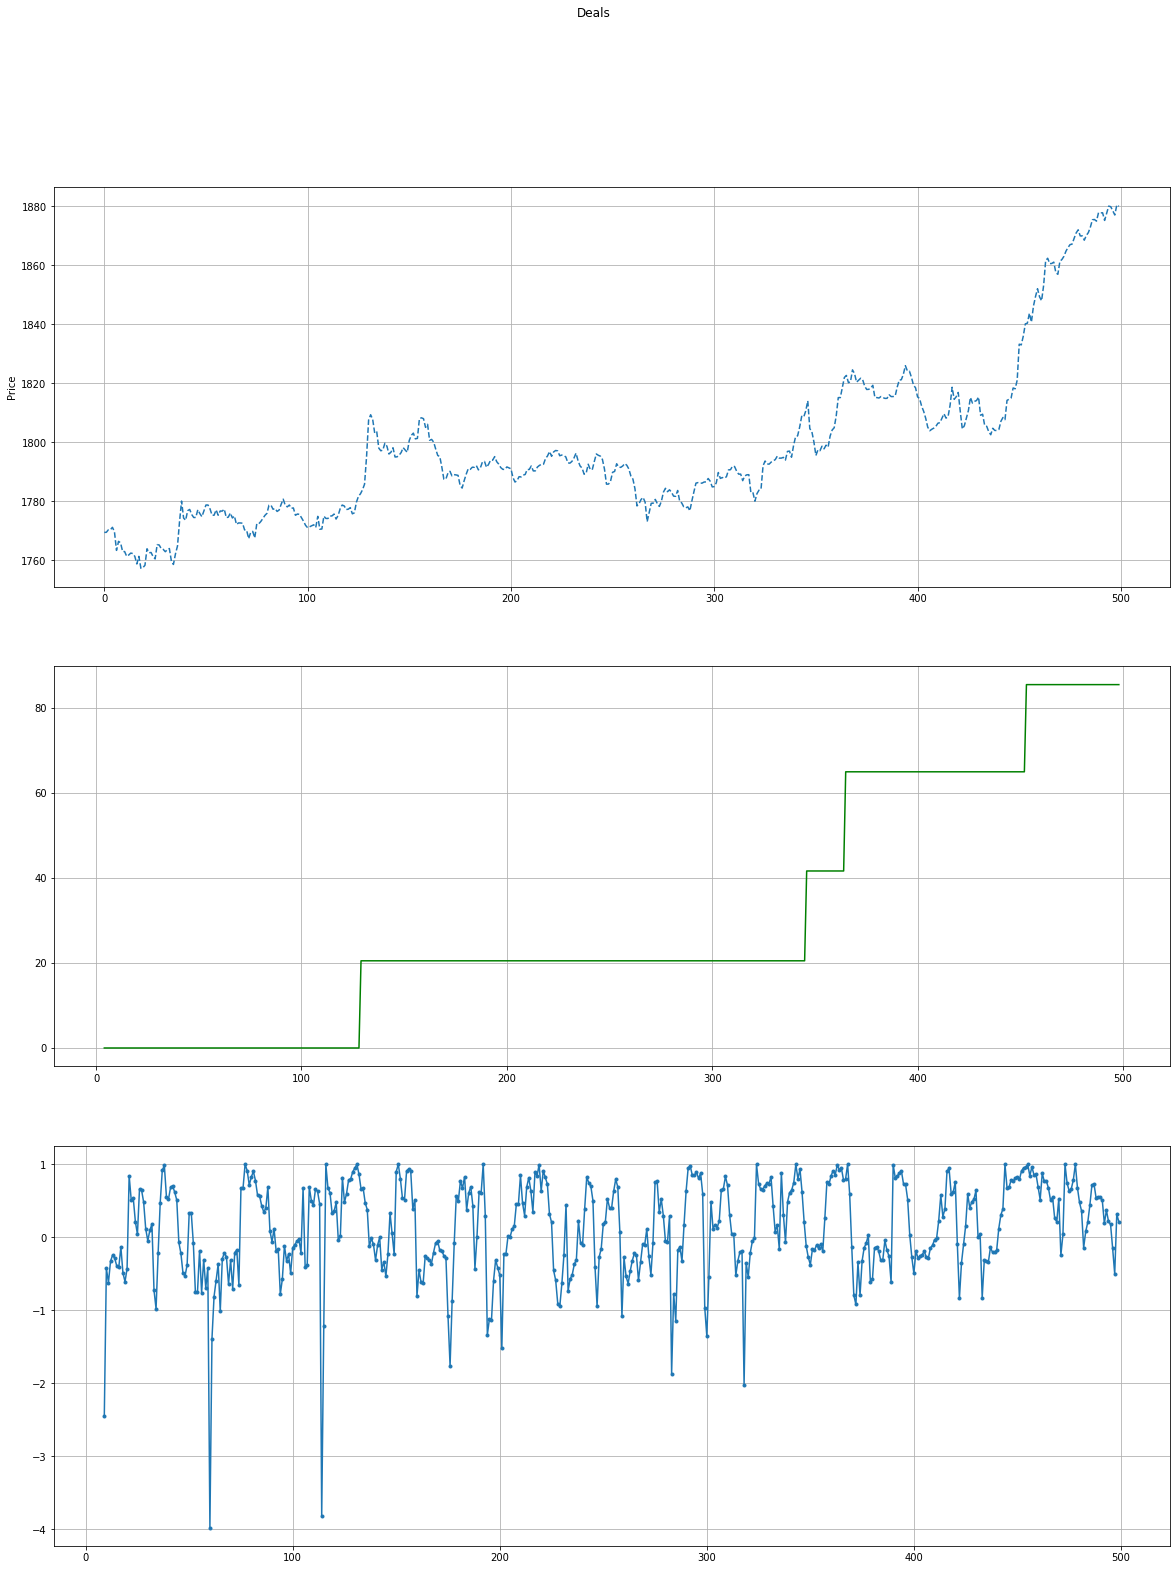

In [21]:
#test run WITH optimazed values

temp_result, temp_df, take_profit_array = run_control_test(vals, lot_size=1)


print(temp_result)
visualize(temp_df)

In [ ]:
##results_array.to_csv('out10K.csv') 

   direc: array([[7.75483434e-05]])
     fun: array(-367)
 message: 'Optimization terminated successfully.'
    nfev: 85
     nit: 2
  status: 0
 success: True
       x: array([3.98241251])

In [20]:
### visualisation
def visualize(prepared_df):
    aa = prepared_df
    aa=aa.reset_index()

    labels = ['close',"deal_o","deal_c"]
    #labels = ['close',"deal_o","deal_c","channel_max","channel_min"]
    #labels = ['close',"channel_max","channel_min"]

    labels_line = ['--',"g-","r-"]


    j=0
    x = pd.DataFrame()
    y = pd.DataFrame()
    for i in labels:
        x[j]=aa['index']
        y[j]=aa[i]
        j=j+1

    fig, (ax1, ax2,ax3) = plt.subplots(3, 1)

    fig.suptitle('Deals')
    fig.set_size_inches(20, 25)

    for j in range(0,len(labels)):
        ax1.plot(x[j], y[j], labels_line[j])


    ax1.set_ylabel('Price')
    ax1.grid(True)

    ax2.plot(x[0], aa['earn'], 'g-') #EMA
    ax3.plot(x[0], aa['position_in_channel'], '.-') #EMA

    ax2.grid(True)
    ax3.grid(True)

    plt.show()

